In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housesalesprice/train.csv
/kaggle/input/housesalesprice/test.csv


In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.model_selection import train_test_split, cross_validate
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score




pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)


In [3]:

traindata=pd.read_csv("/kaggle/input/housesalesprice/train.csv")
traindata.head()
traindata.isnull().sum()
testdata=pd.read_csv("/kaggle/input/housesalesprice/test.csv")
testdata.head()
df=pd.concat([traindata,testdata],ignore_index=True)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [4]:

for i in df.columns:
    print(f"Sütun adı: {i}\n"
          f"Nunique Değer Sayısı: {df[i].nunique()}")


Sütun adı: Id
Nunique Değer Sayısı: 2919
Sütun adı: MSSubClass
Nunique Değer Sayısı: 16
Sütun adı: MSZoning
Nunique Değer Sayısı: 5
Sütun adı: LotFrontage
Nunique Değer Sayısı: 128
Sütun adı: LotArea
Nunique Değer Sayısı: 1951
Sütun adı: Street
Nunique Değer Sayısı: 2
Sütun adı: Alley
Nunique Değer Sayısı: 2
Sütun adı: LotShape
Nunique Değer Sayısı: 4
Sütun adı: LandContour
Nunique Değer Sayısı: 4
Sütun adı: Utilities
Nunique Değer Sayısı: 2
Sütun adı: LotConfig
Nunique Değer Sayısı: 5
Sütun adı: LandSlope
Nunique Değer Sayısı: 3
Sütun adı: Neighborhood
Nunique Değer Sayısı: 25
Sütun adı: Condition1
Nunique Değer Sayısı: 9
Sütun adı: Condition2
Nunique Değer Sayısı: 8
Sütun adı: BldgType
Nunique Değer Sayısı: 5
Sütun adı: HouseStyle
Nunique Değer Sayısı: 8
Sütun adı: OverallQual
Nunique Değer Sayısı: 10
Sütun adı: OverallCond
Nunique Değer Sayısı: 9
Sütun adı: YearBuilt
Nunique Değer Sayısı: 118
Sütun adı: YearRemodAdd
Nunique Değer Sayısı: 61
Sütun adı: RoofStyle
Nunique Değer Sayısı:

In [5]:

def grab_col_names(dataframe, cat_th=10, car_th=25):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "object" or dataframe[col].dtypes.name == "category"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "object" and dataframe[col].dtypes.name != "category"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   (dataframe[col].dtypes == "object" or dataframe[col].dtypes.name == "category")]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "object" and dataframe[col].dtypes.name != "category"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols,cat_but_car,num_but_cat

cat_cols, num_cols,cat_but_car,num_but_cat = grab_col_names(df)

df.info()


Observations: 2919
Variables: 81
cat_cols: 53
num_cols: 28
cat_but_car: 0
num_but_cat: 10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseS

In [6]:


changecol=[col for col in cat_cols if df[col].dtype!="object"]
df[changecol] = df[changecol].astype("object")   ##Kategorik değişkne olup türü  farklı olanları object olarak değiştirirz.
changecol2 = [col for col in num_cols if df[col].dtype not in ["int64", "float64"]]
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

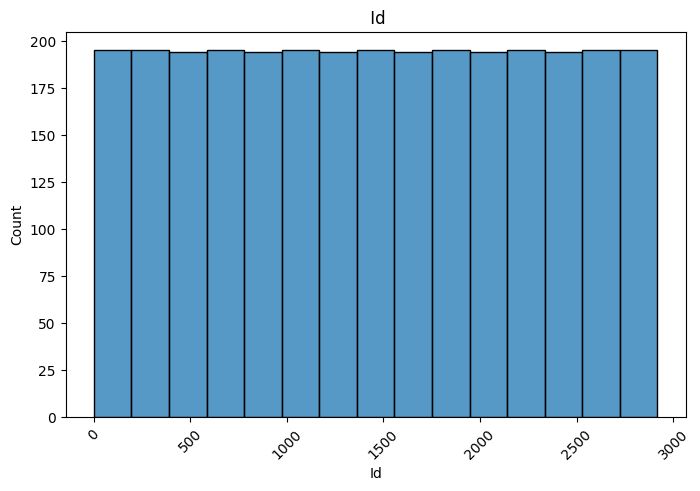

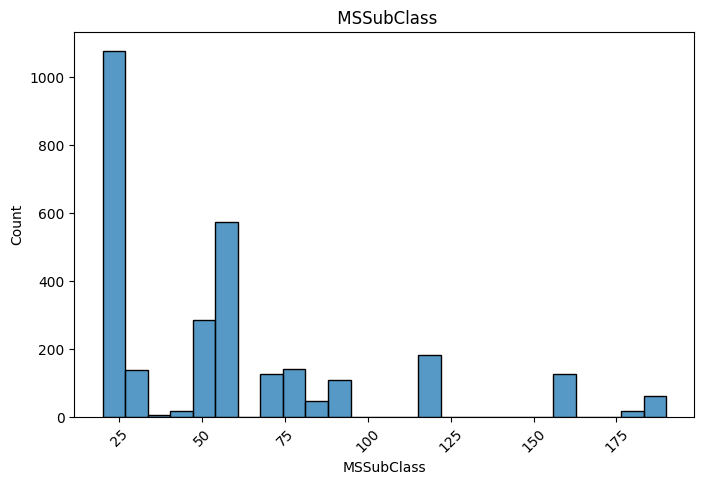

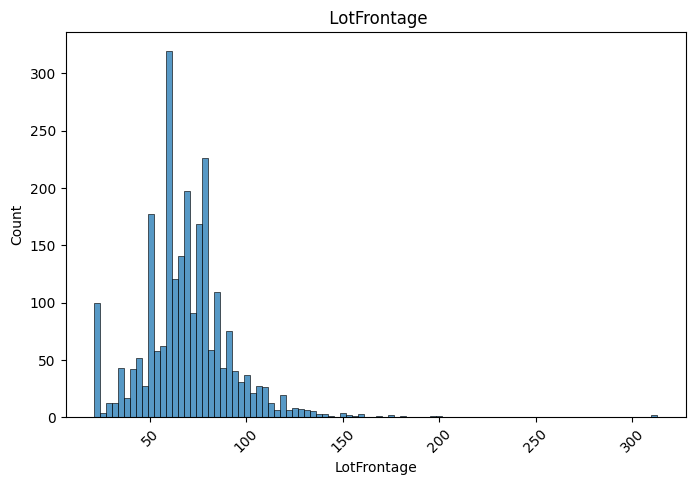

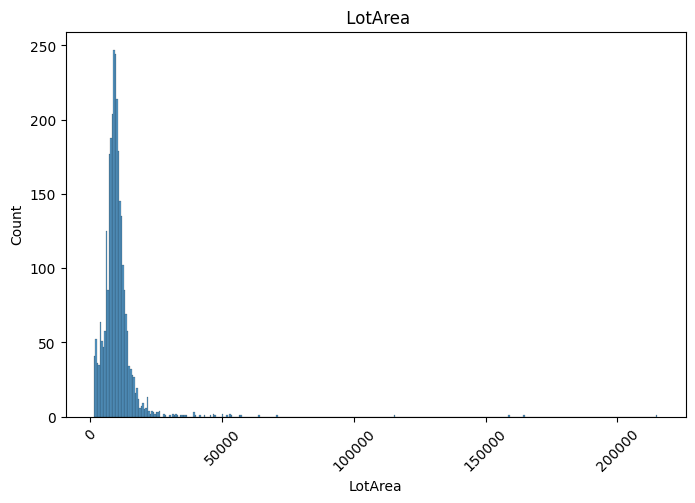

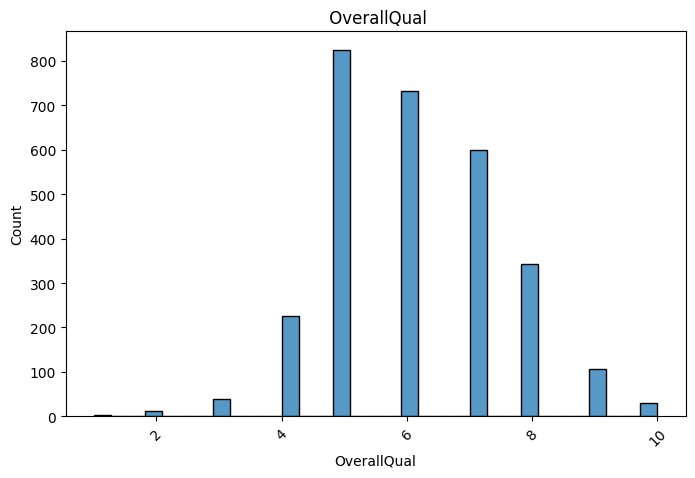

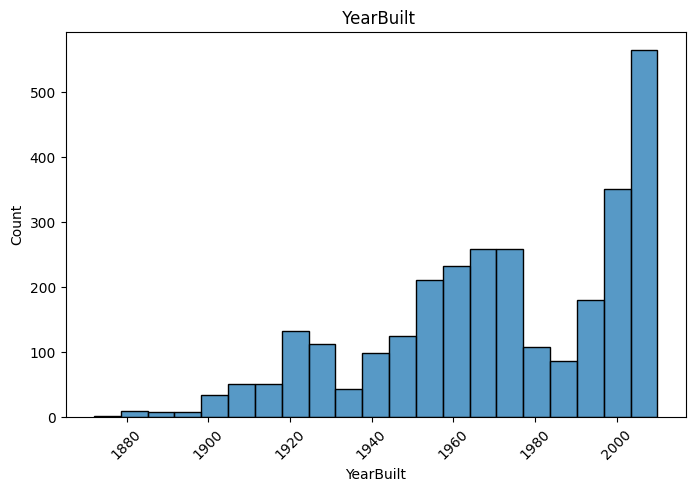

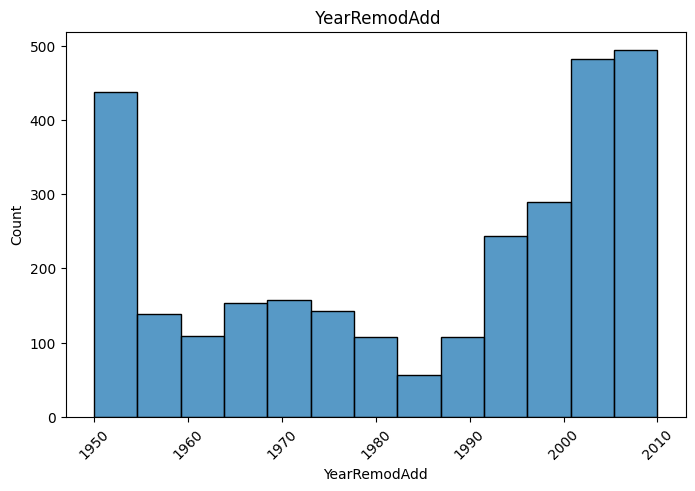

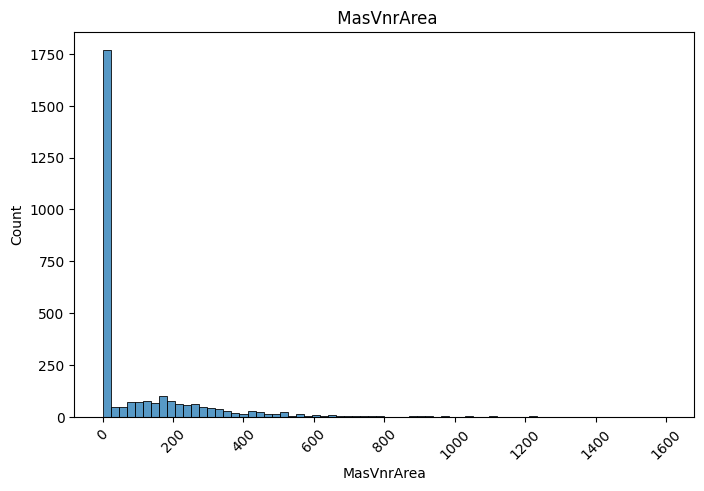

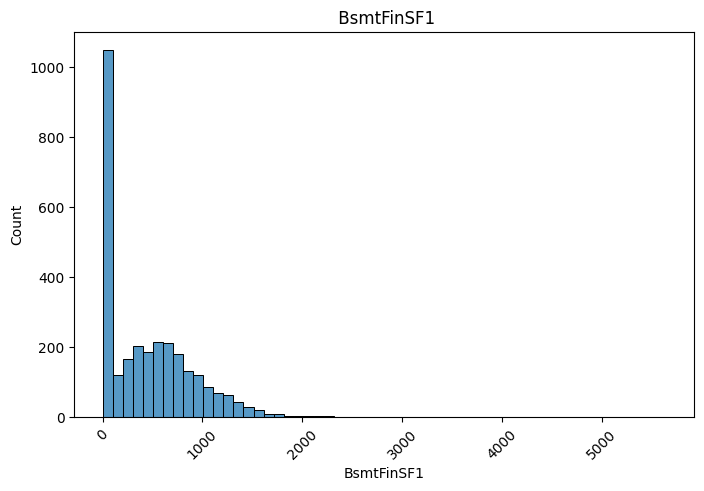

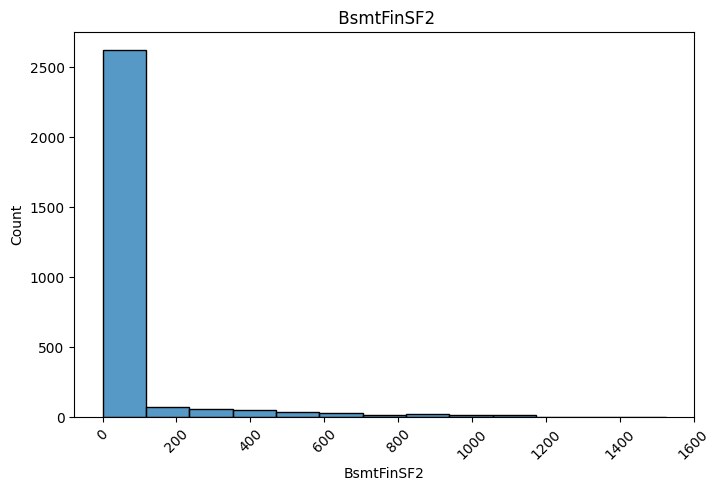

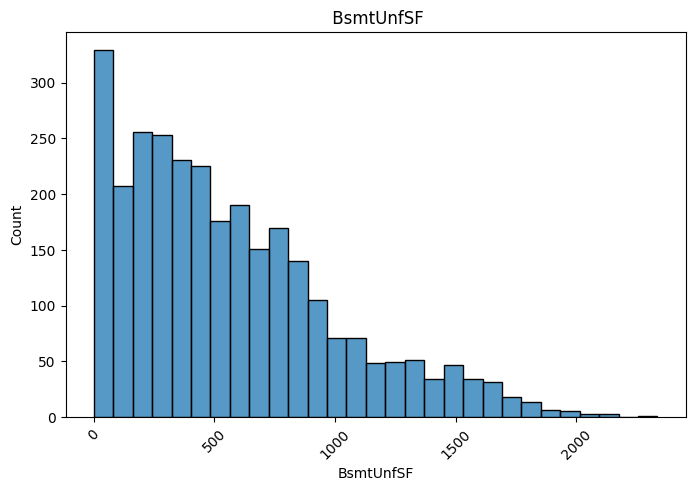

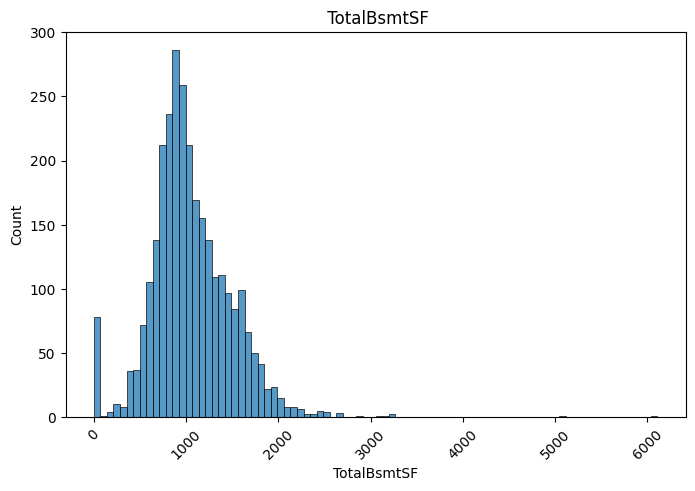

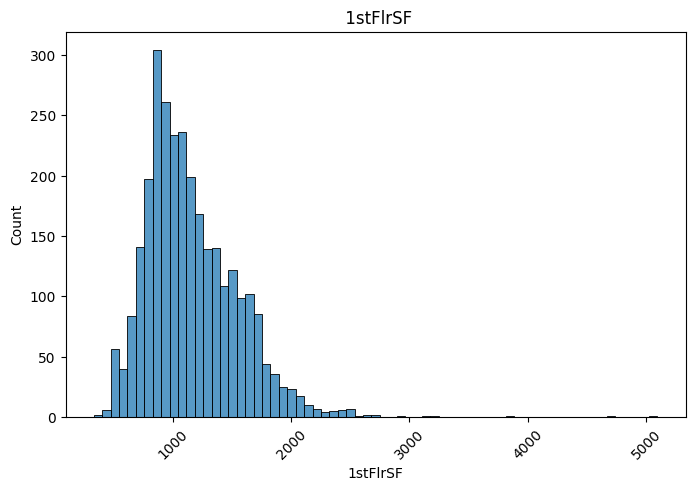

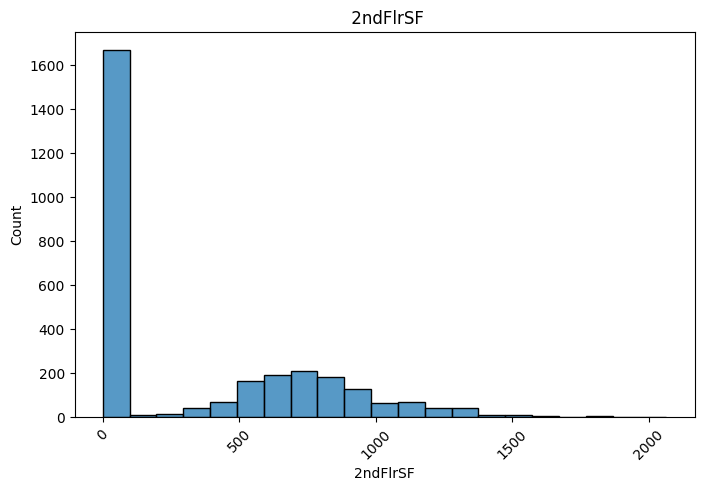

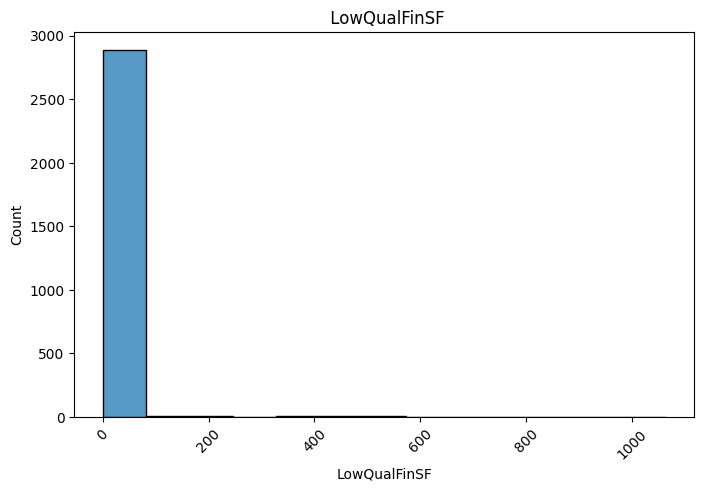

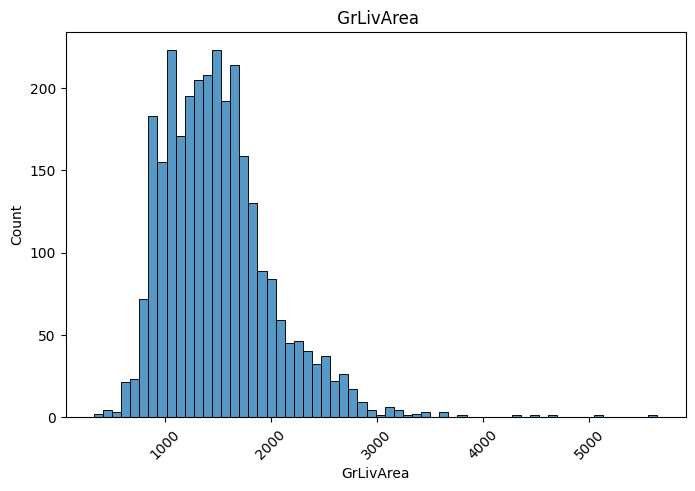

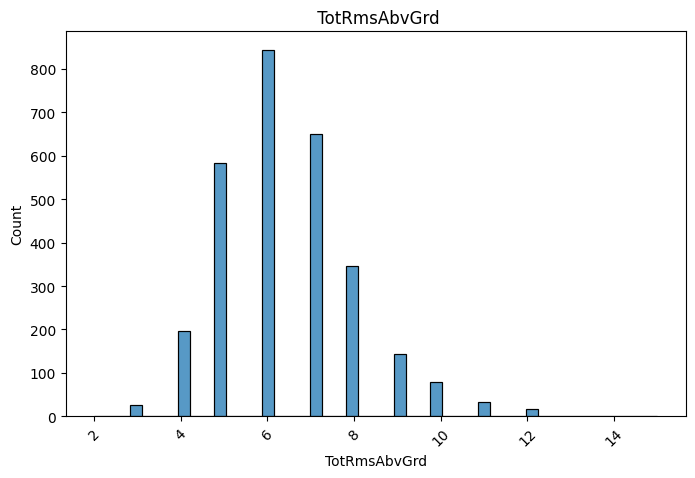

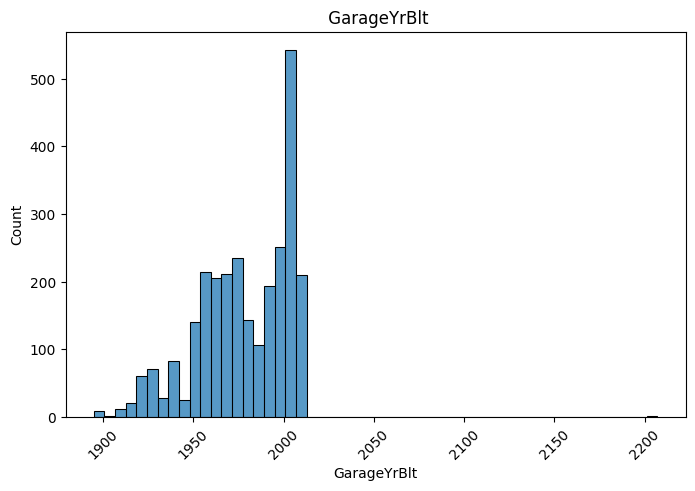

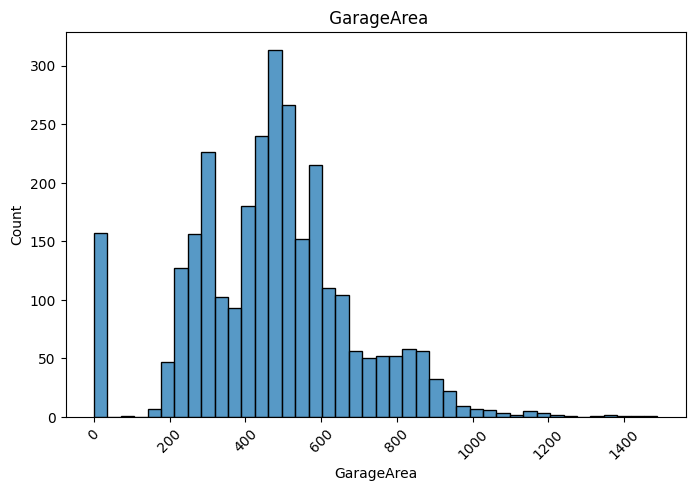

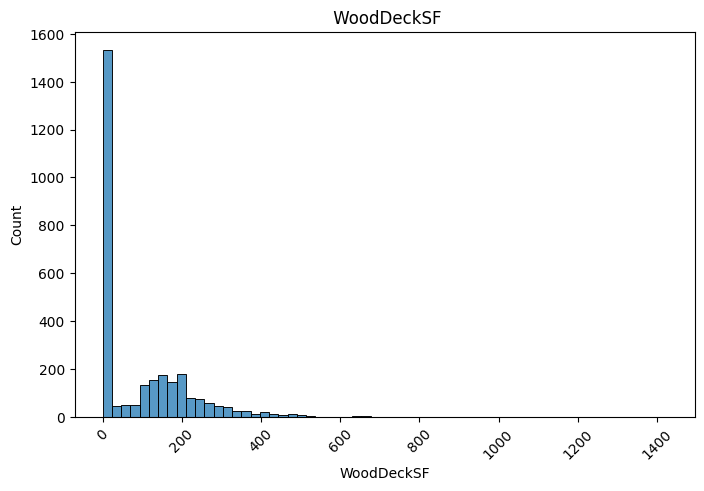

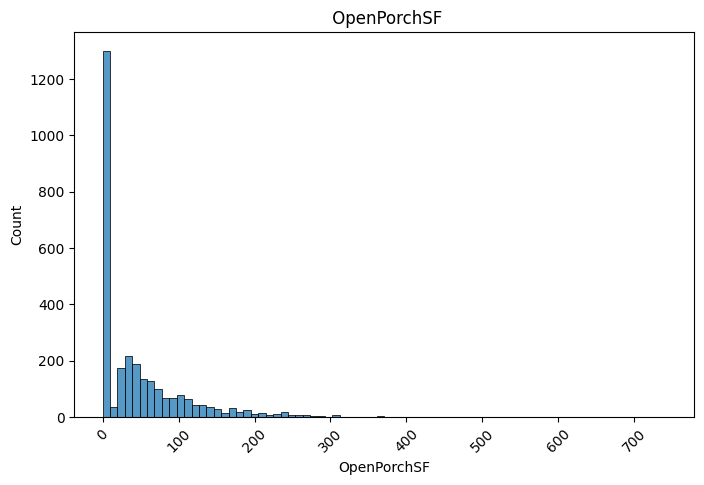

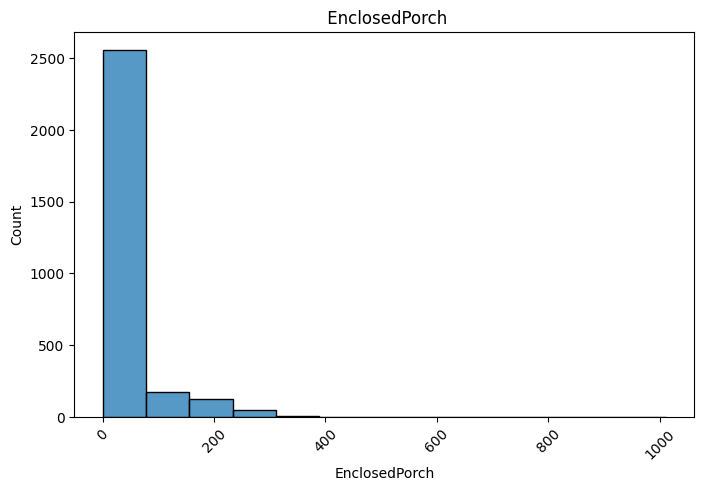

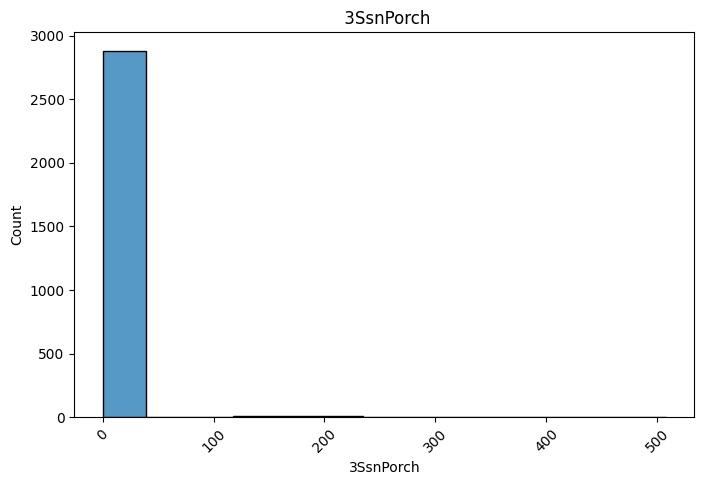

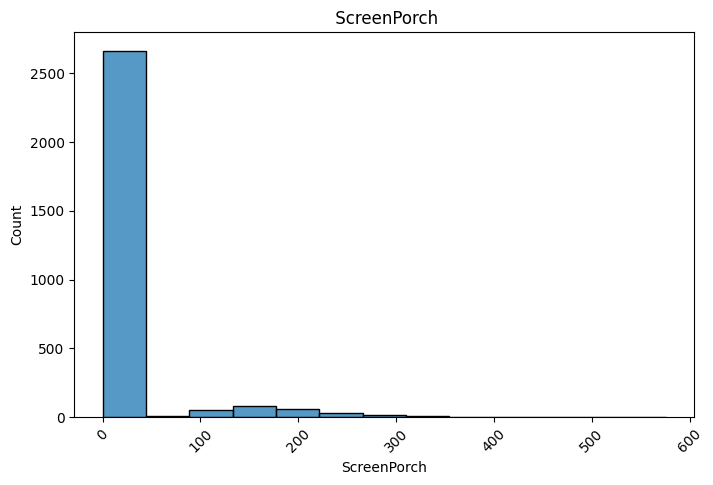

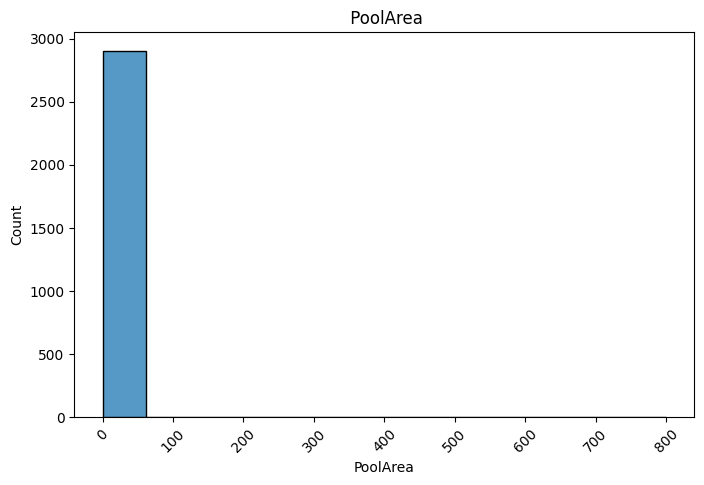

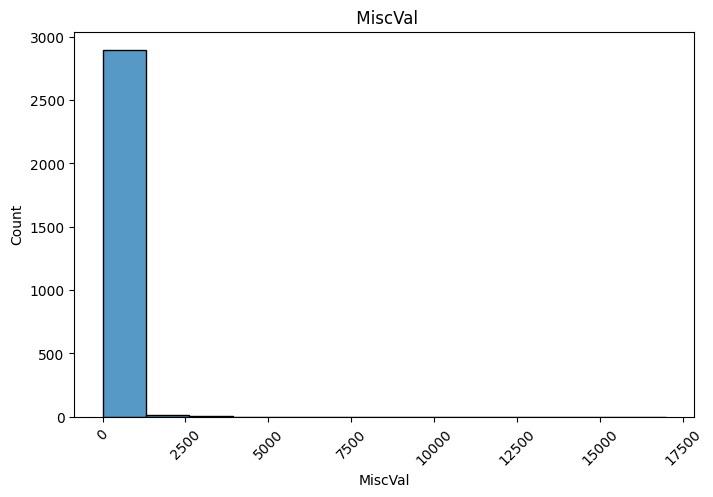

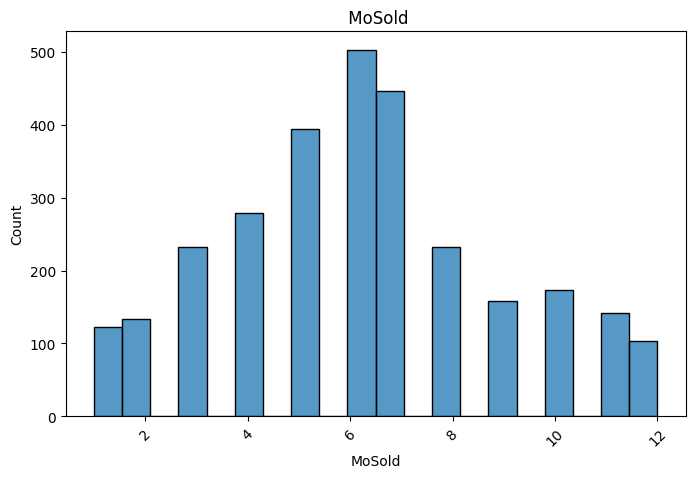

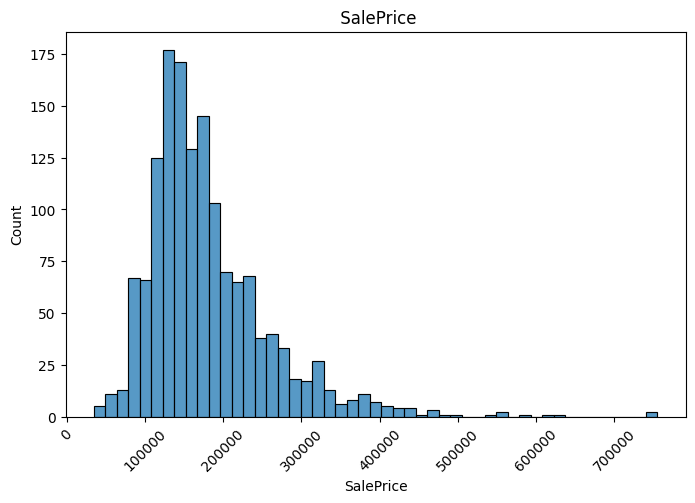

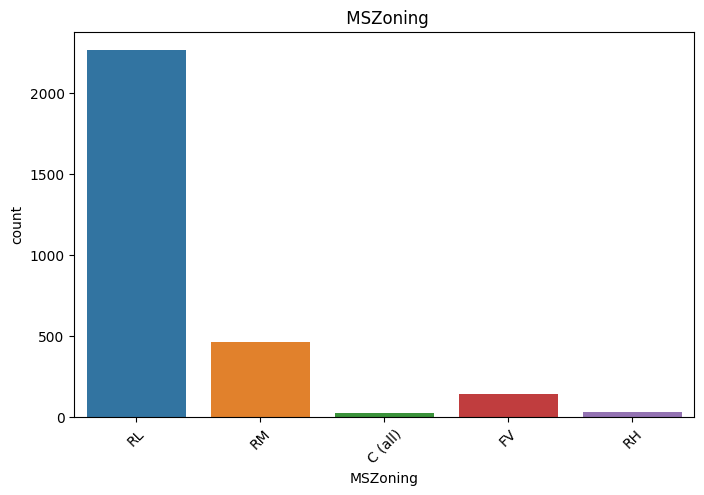

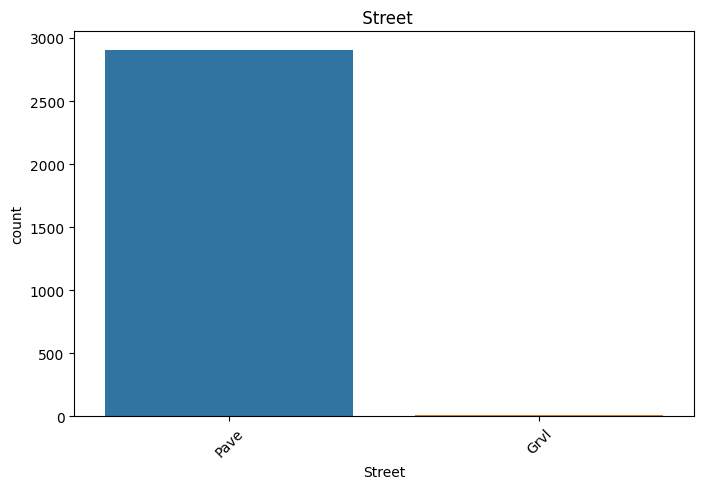

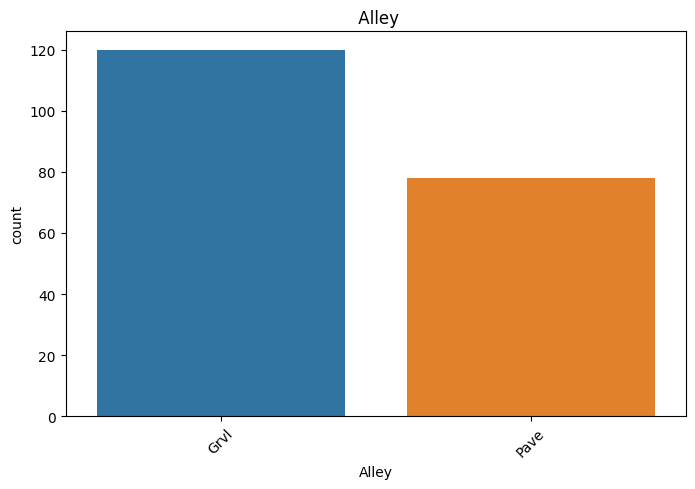

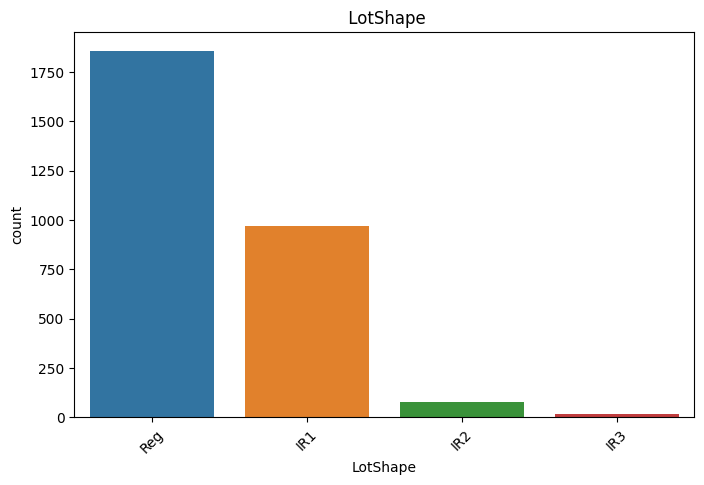

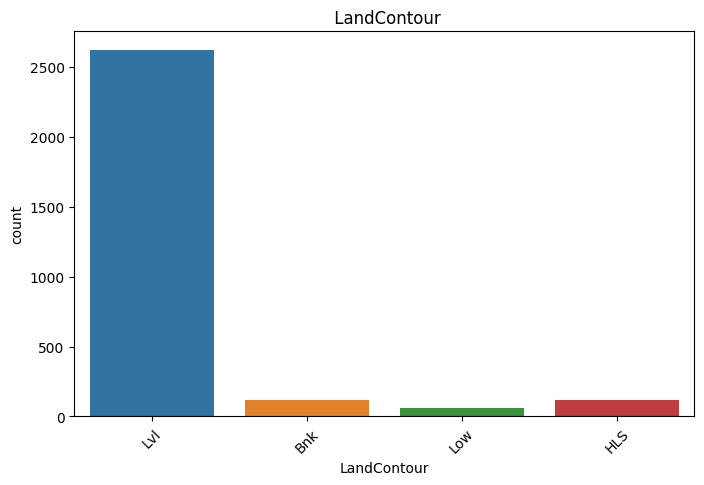

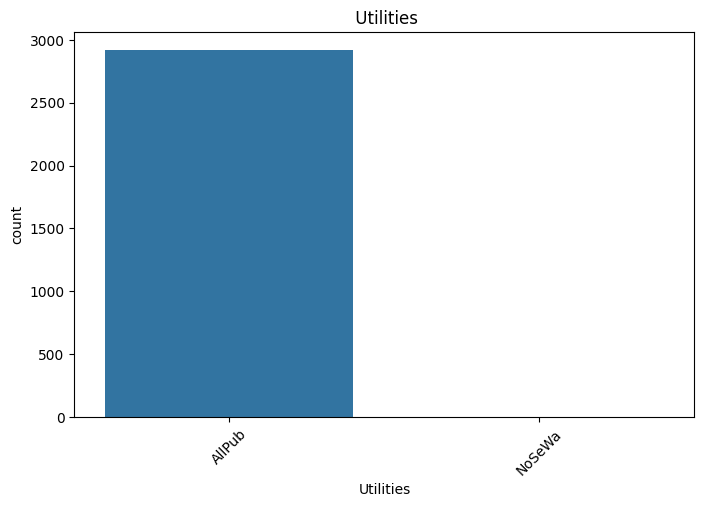

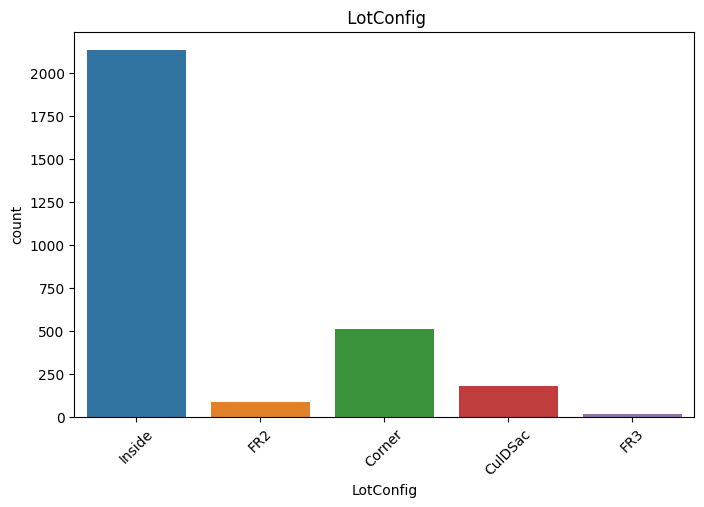

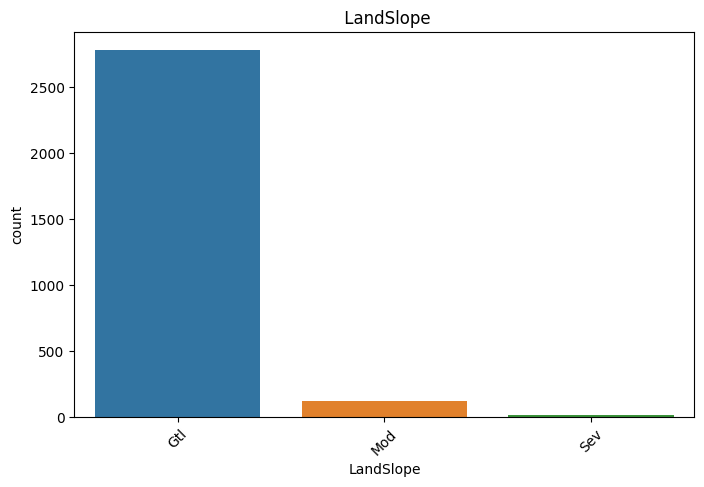

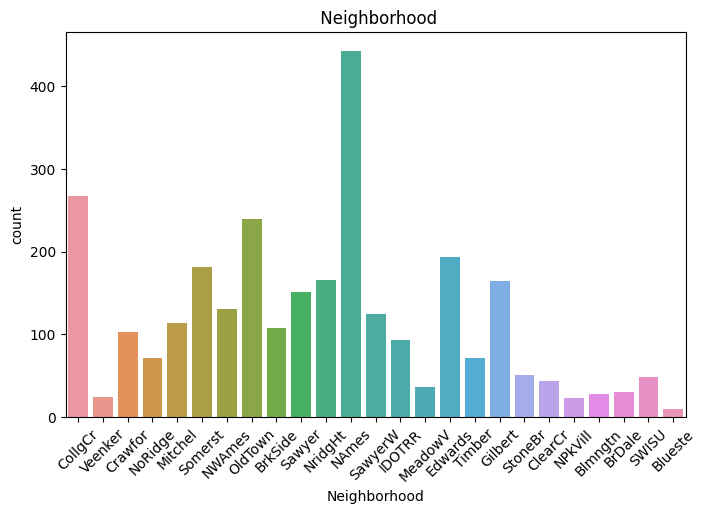

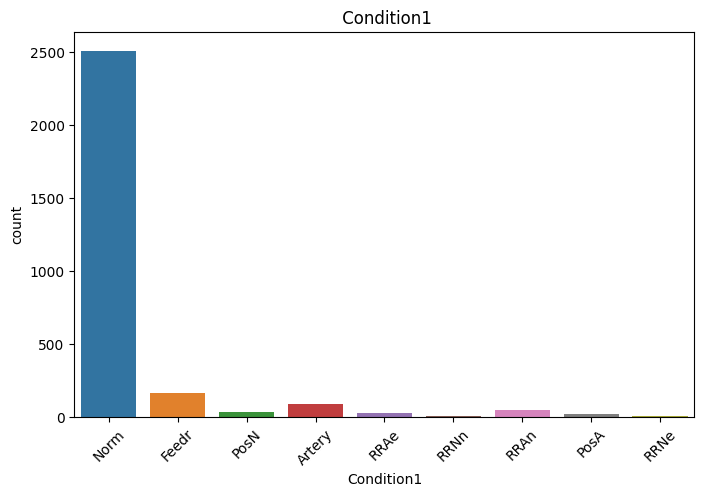

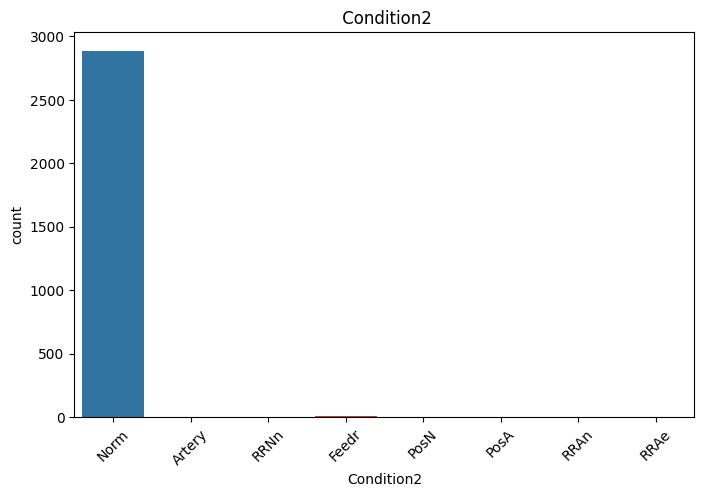

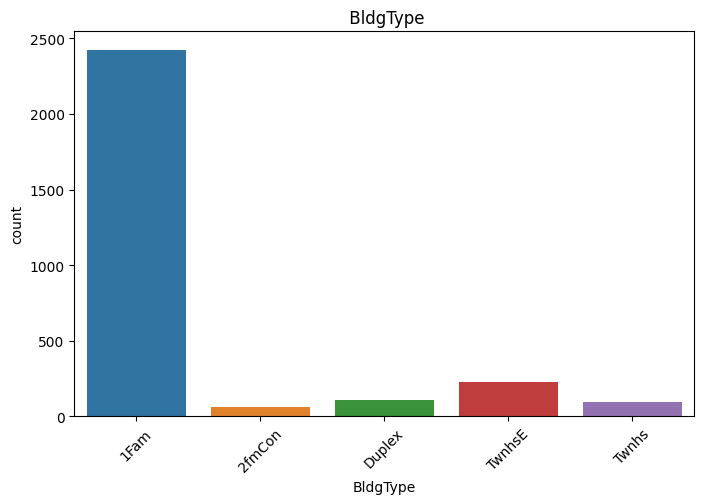

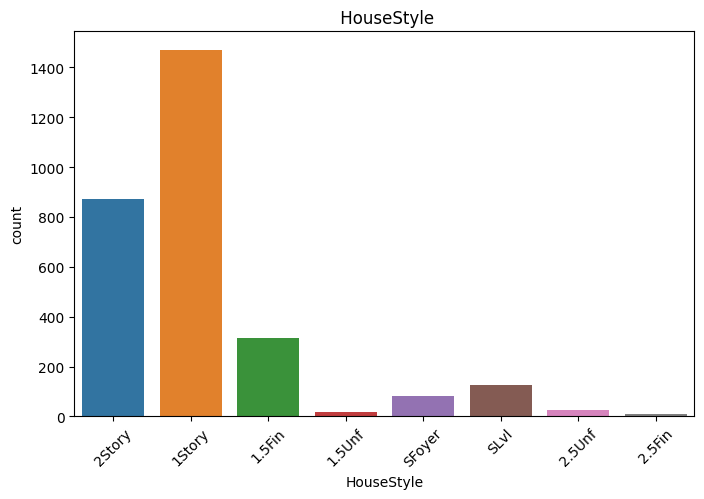

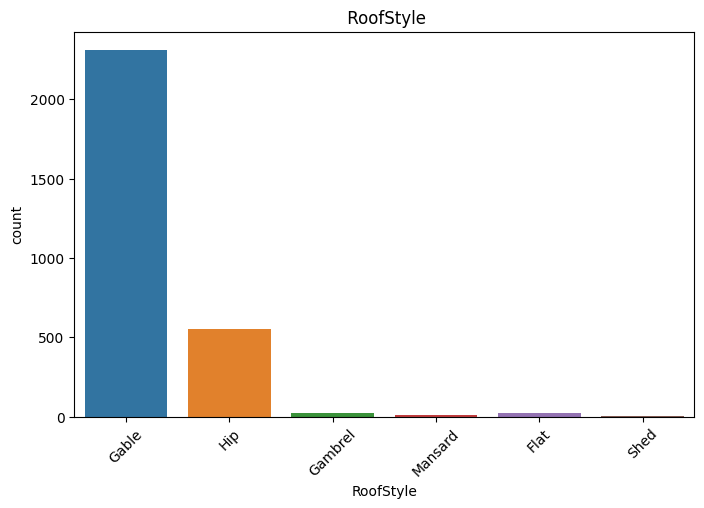

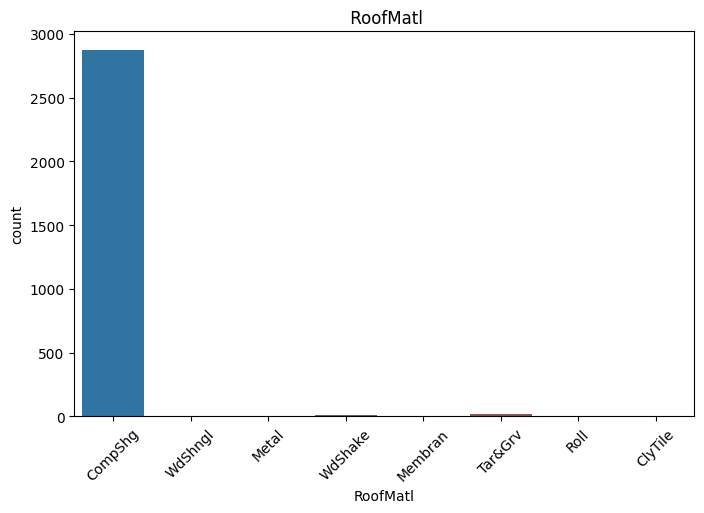

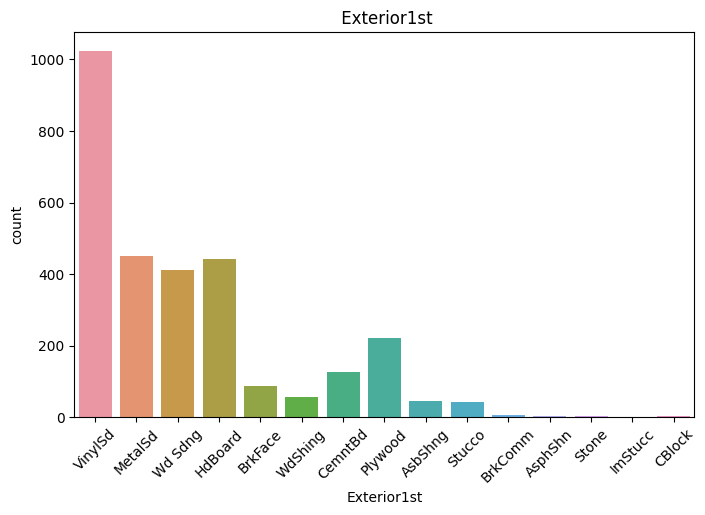

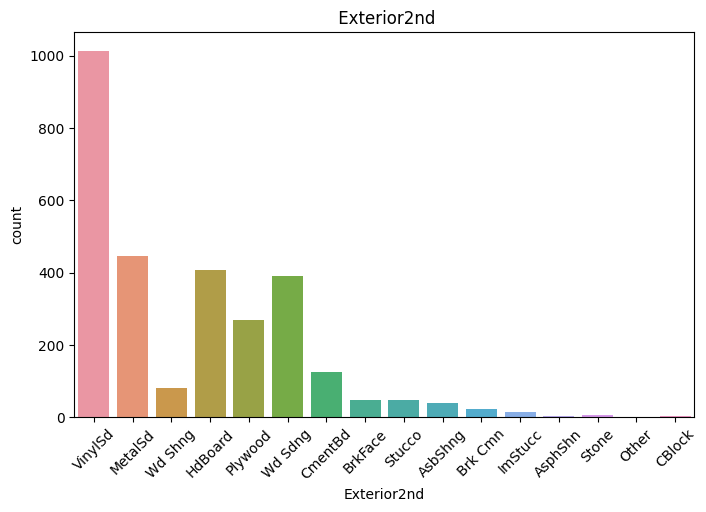

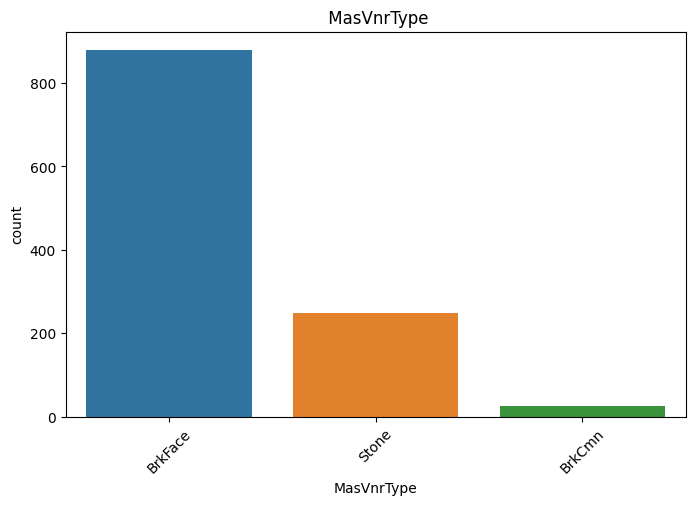

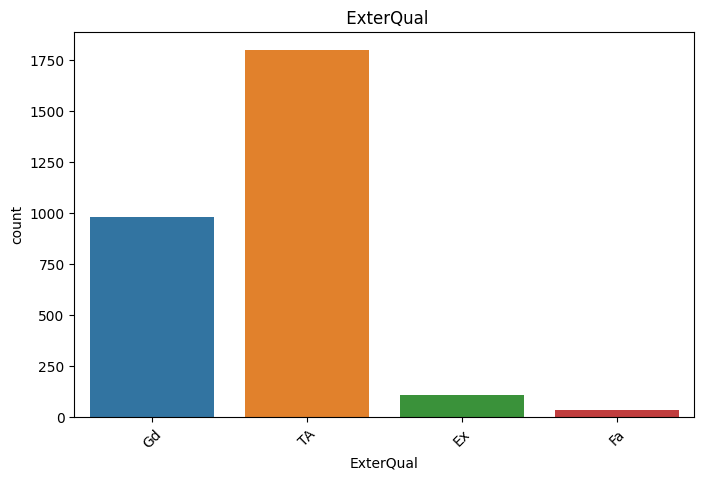

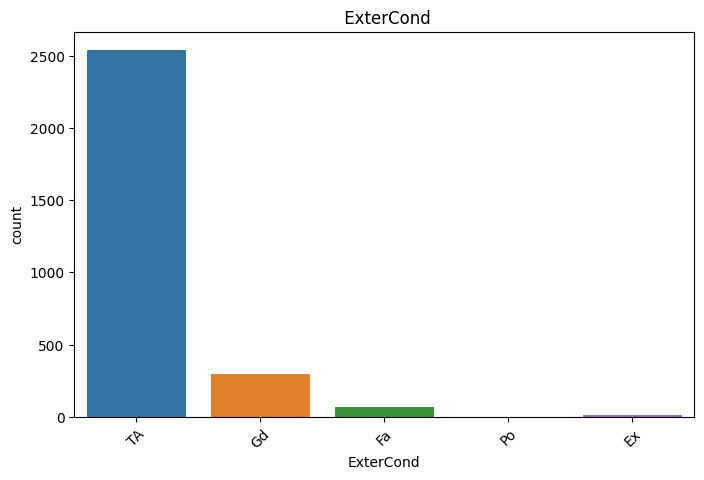

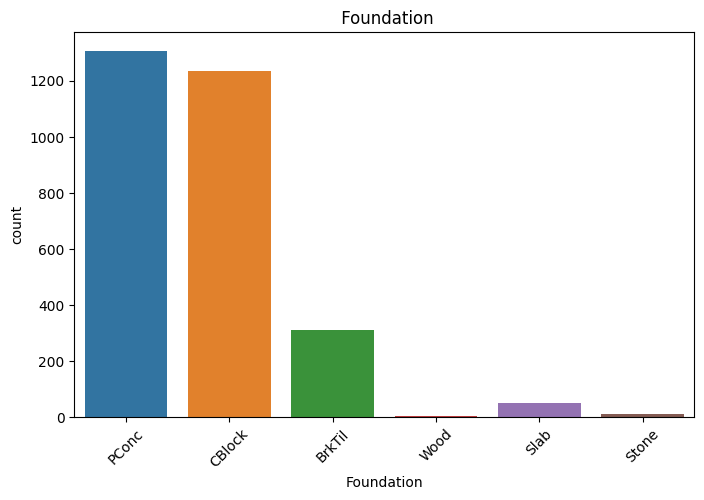

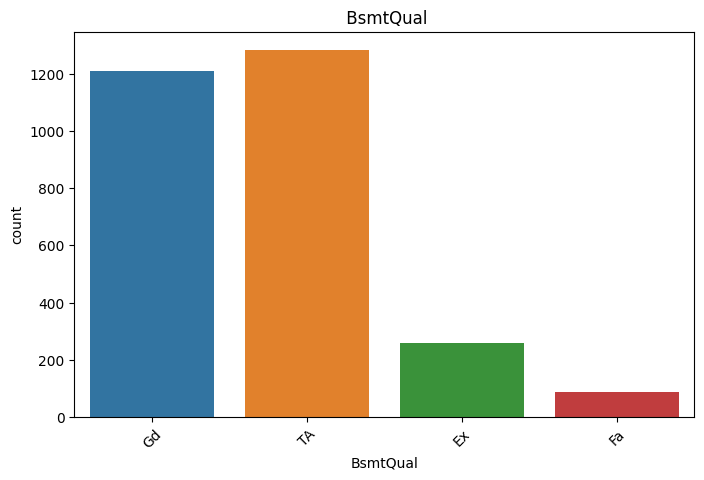

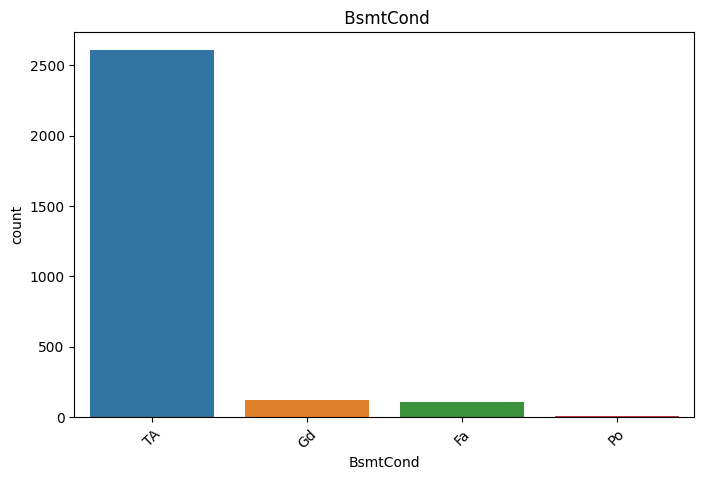

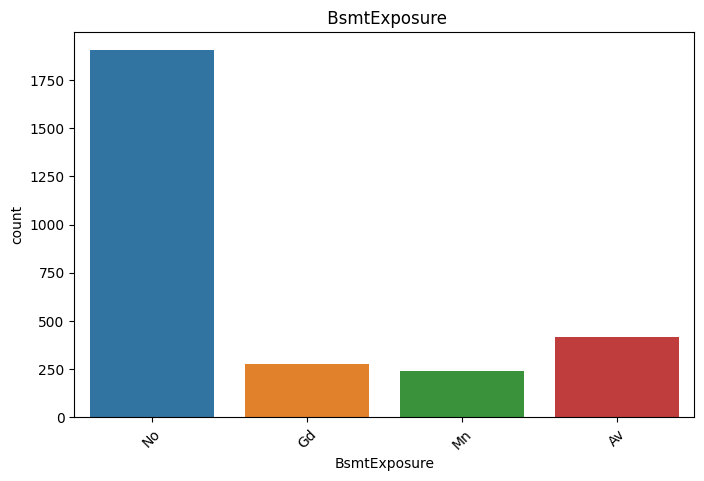

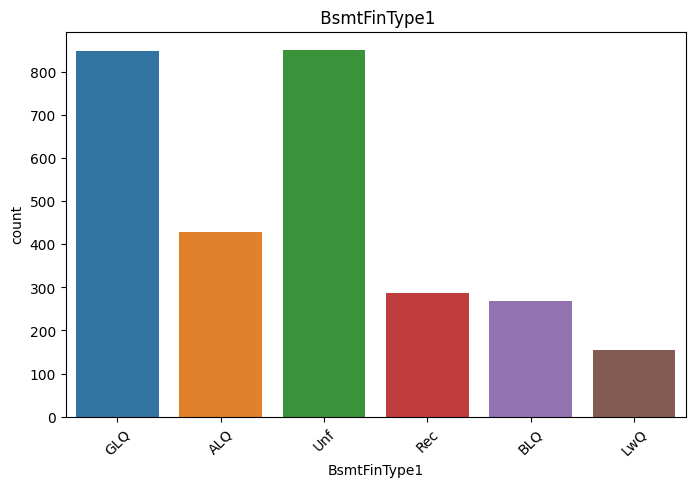

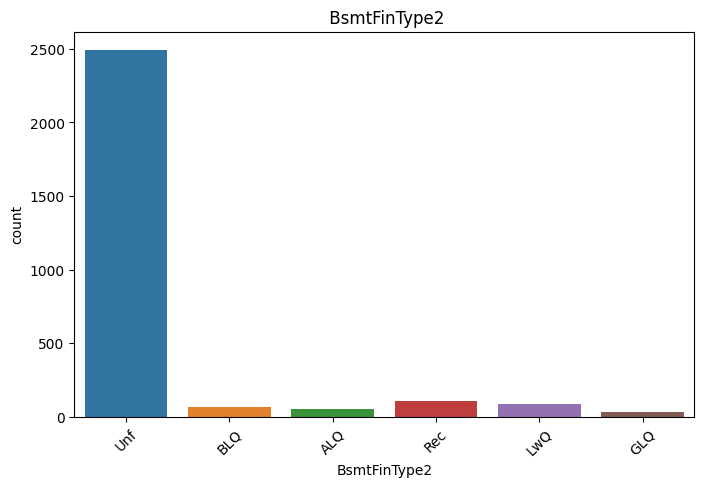

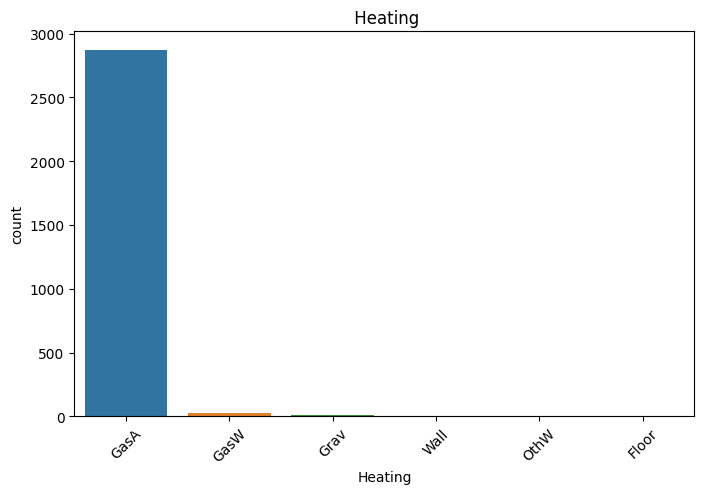

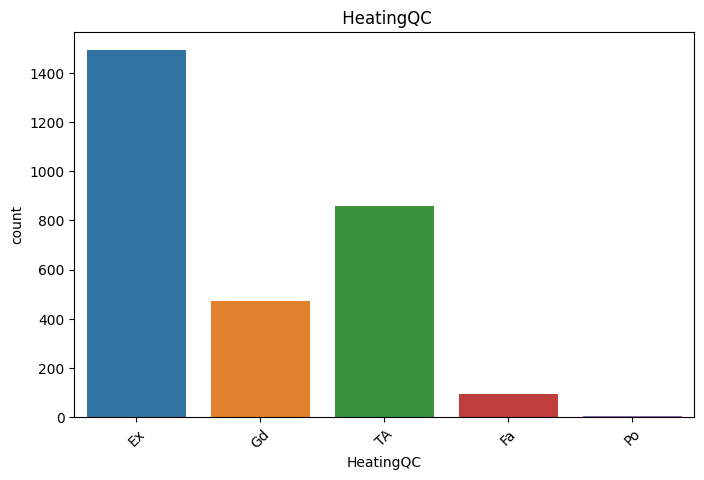

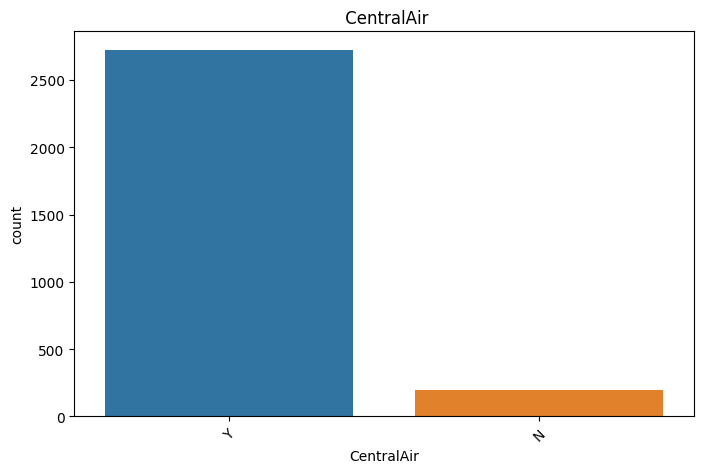

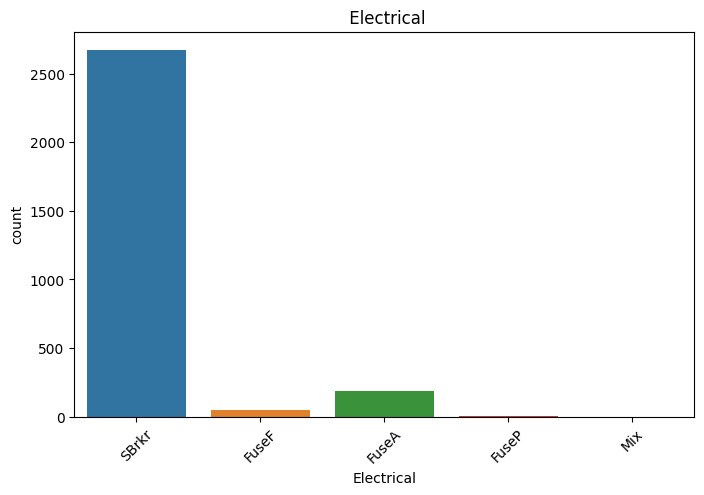

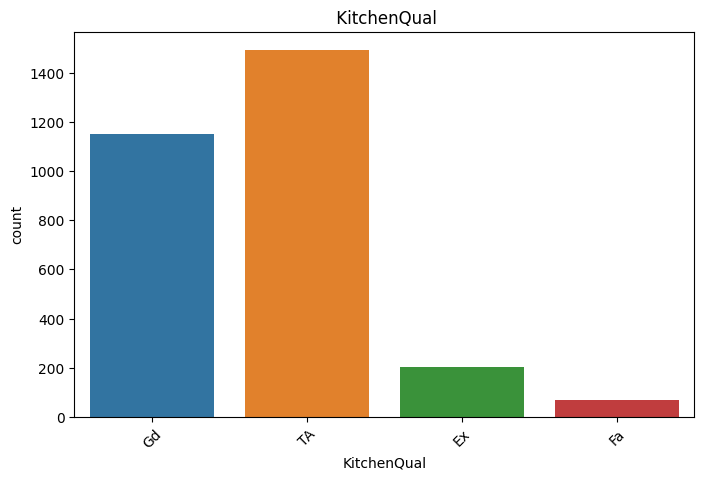

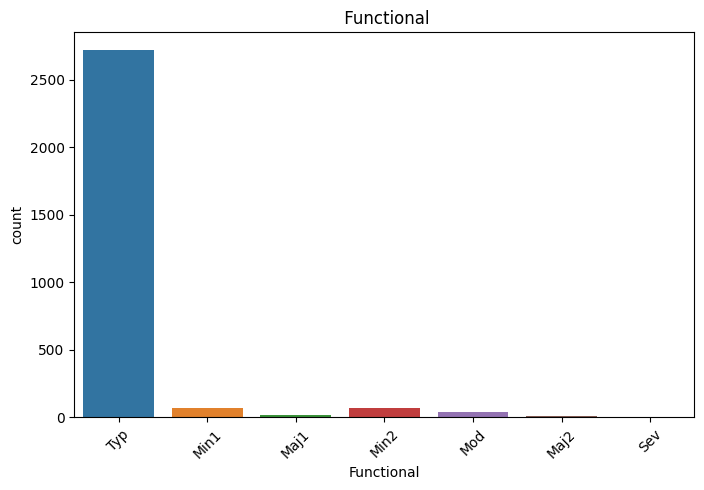

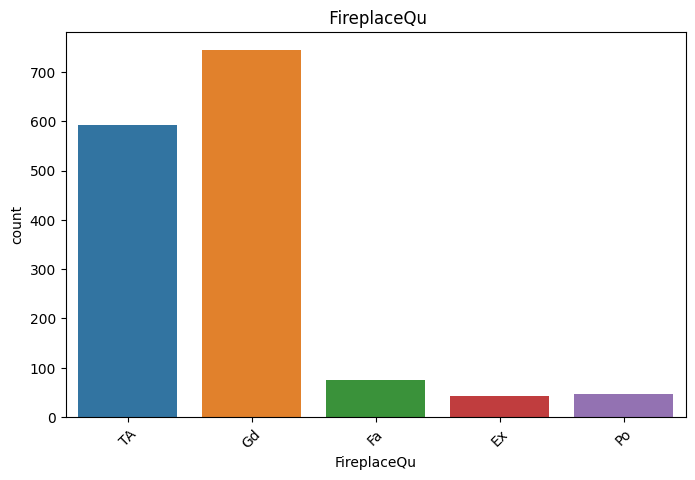

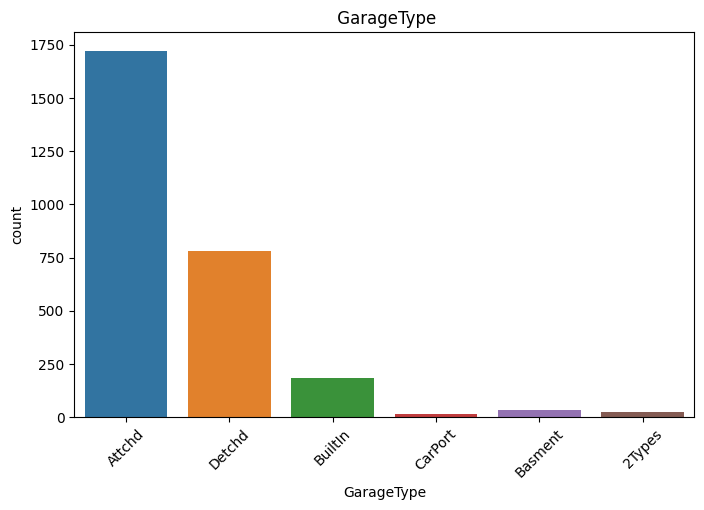

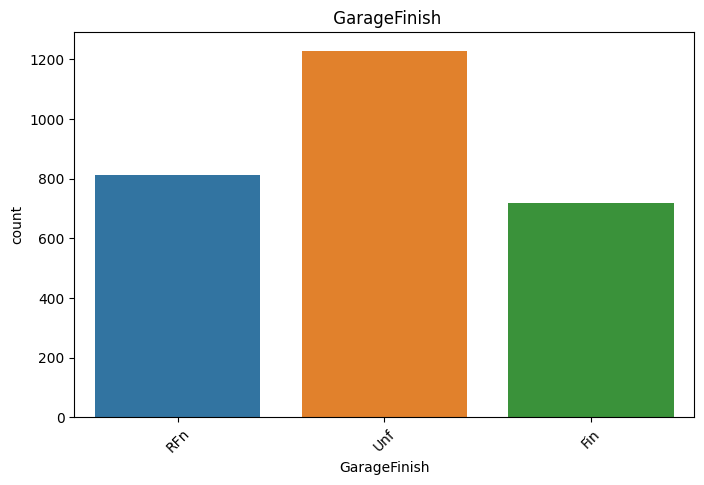

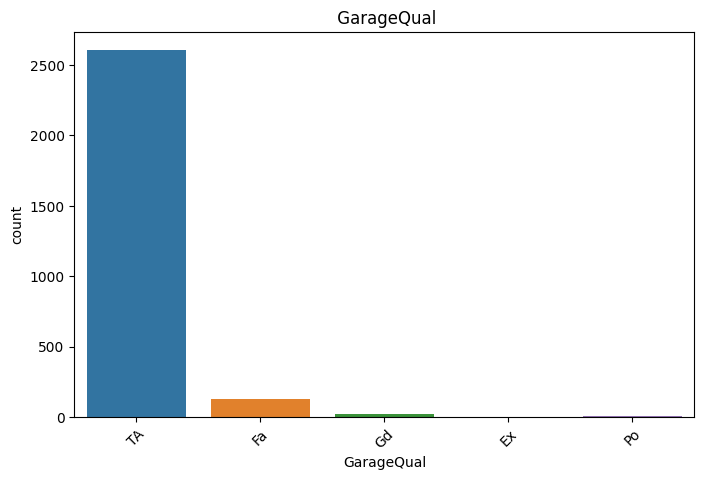

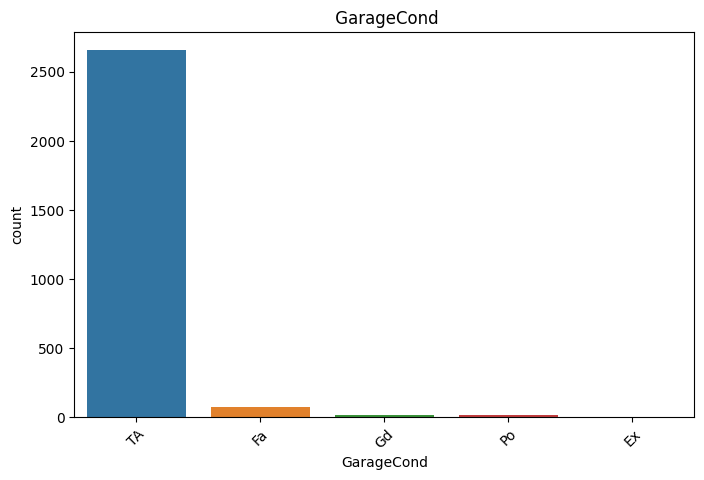

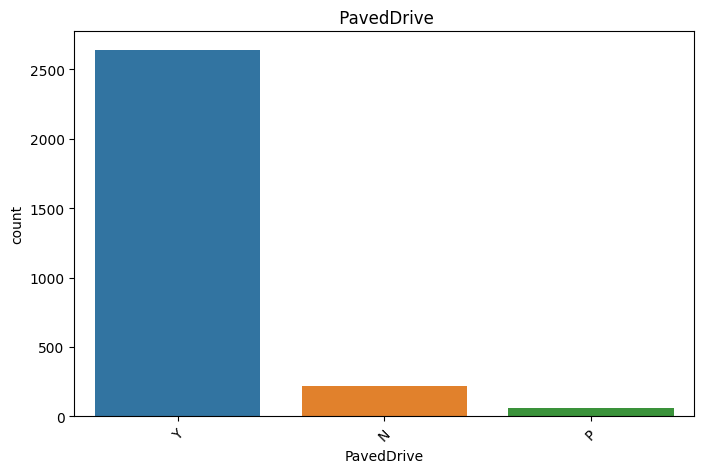

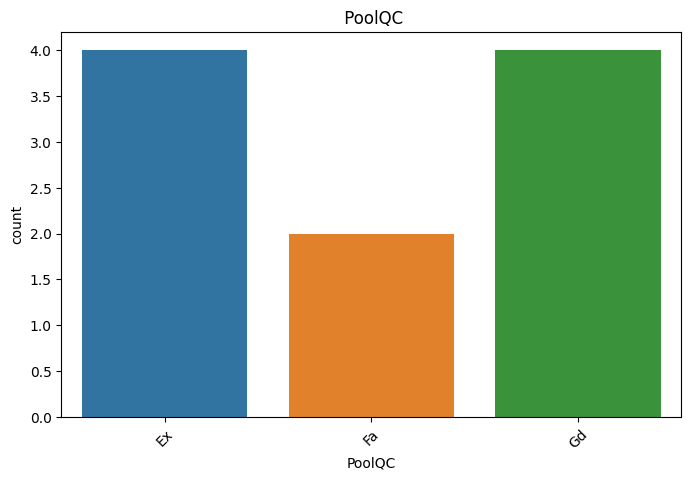

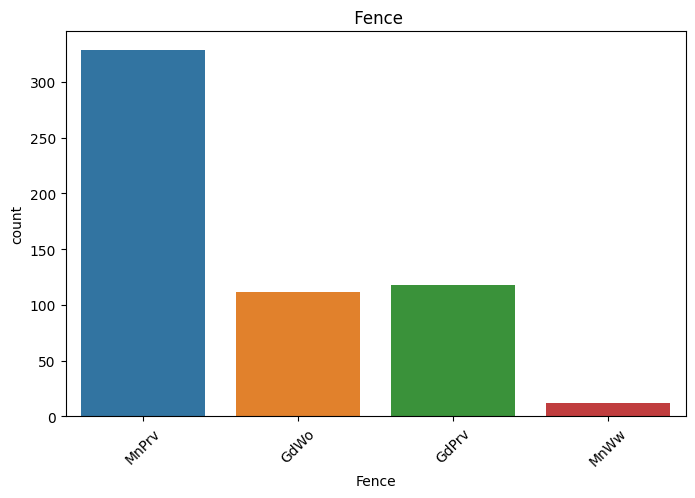

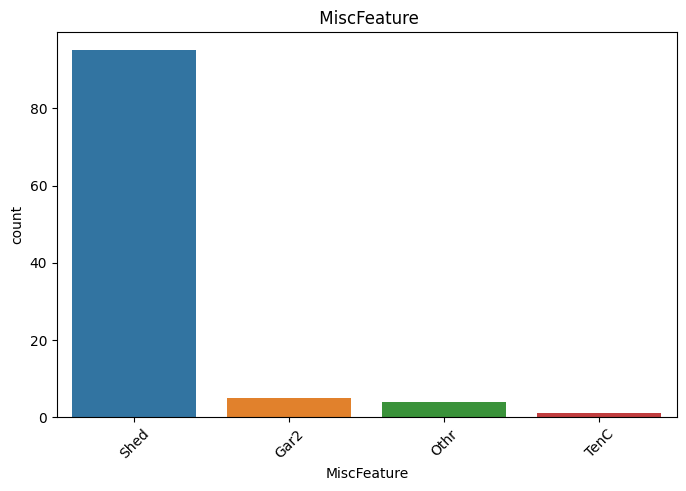

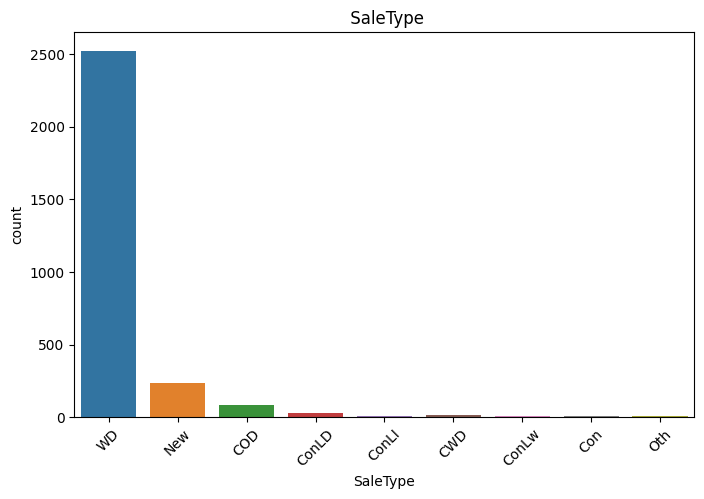

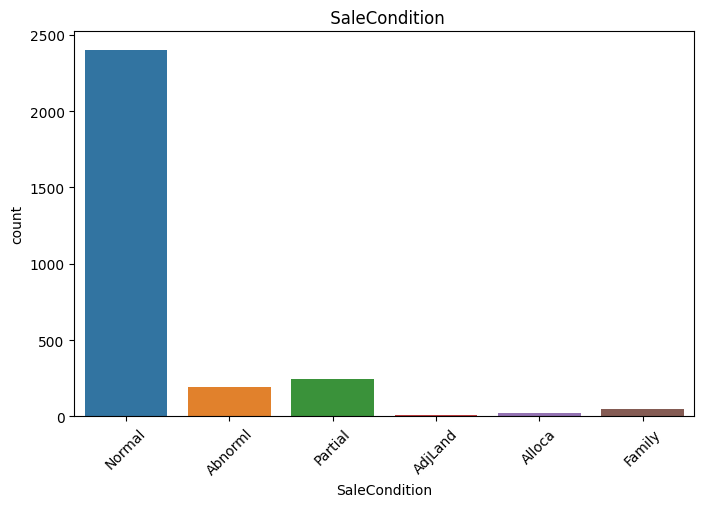

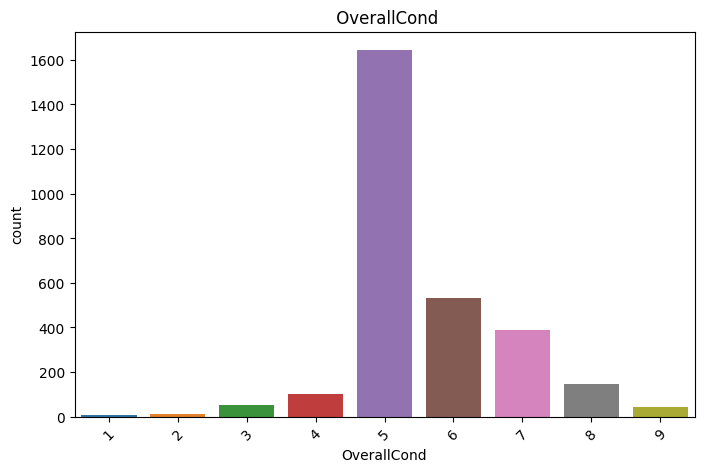

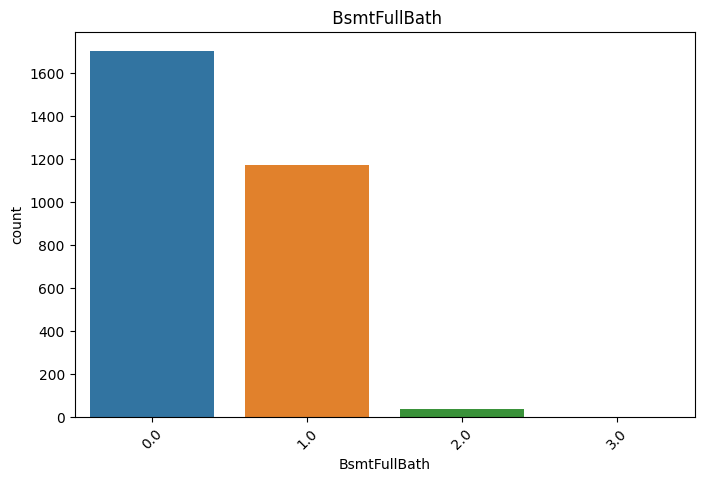

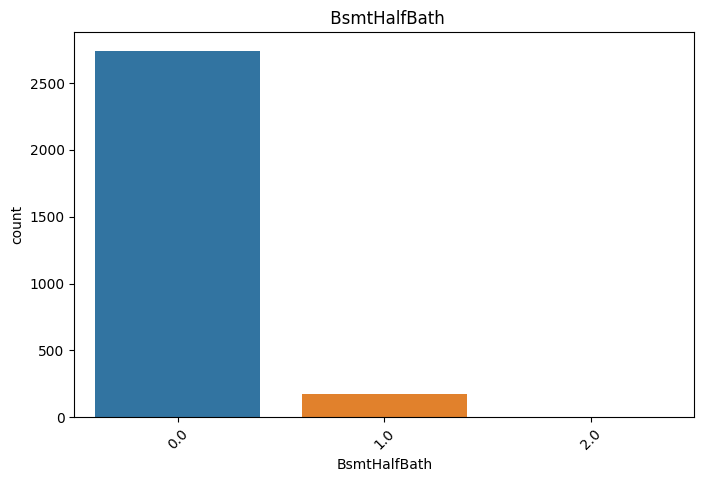

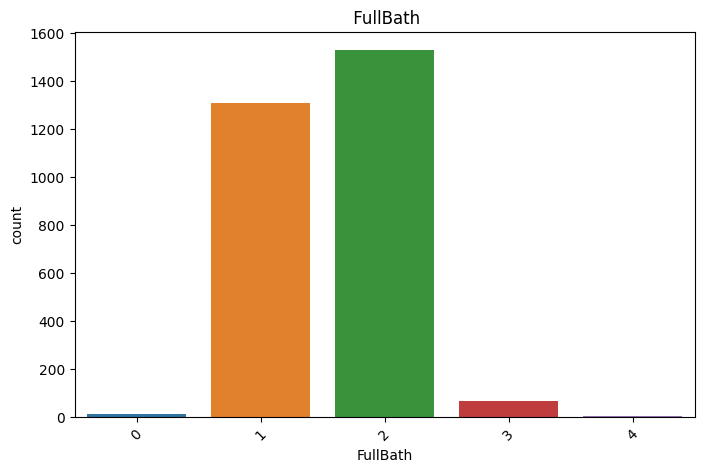

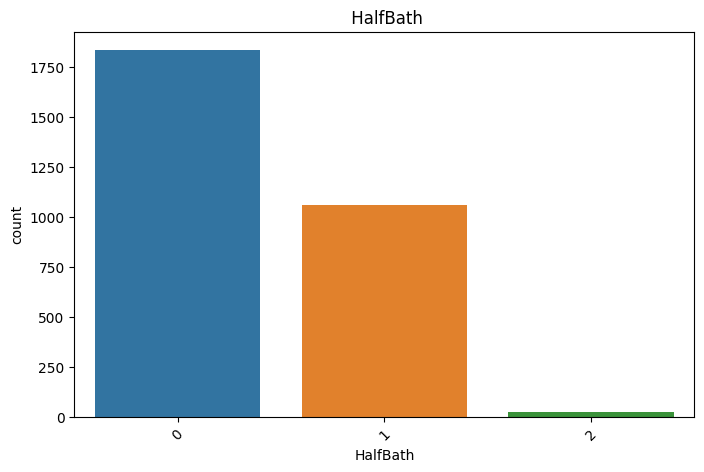

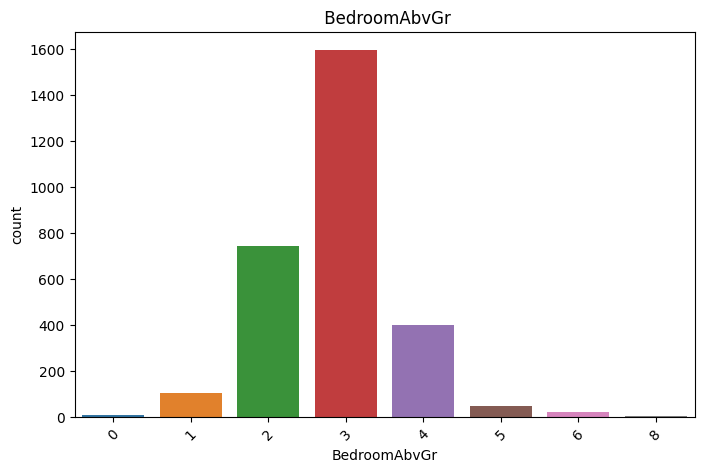

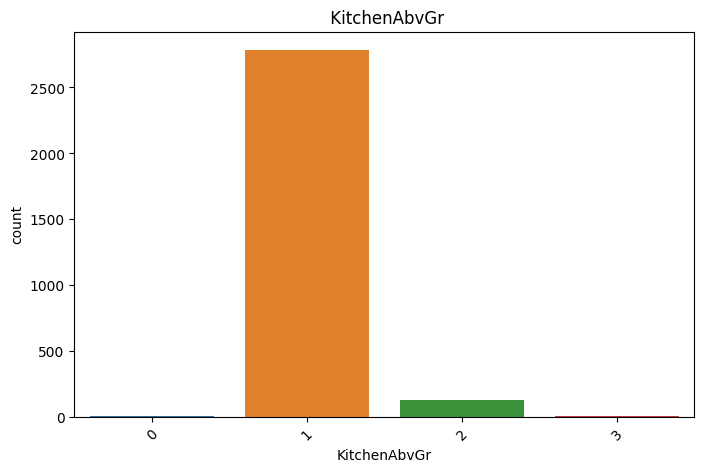

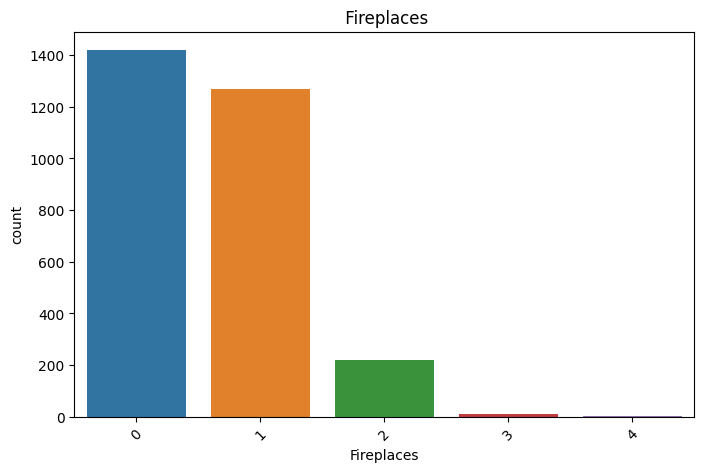

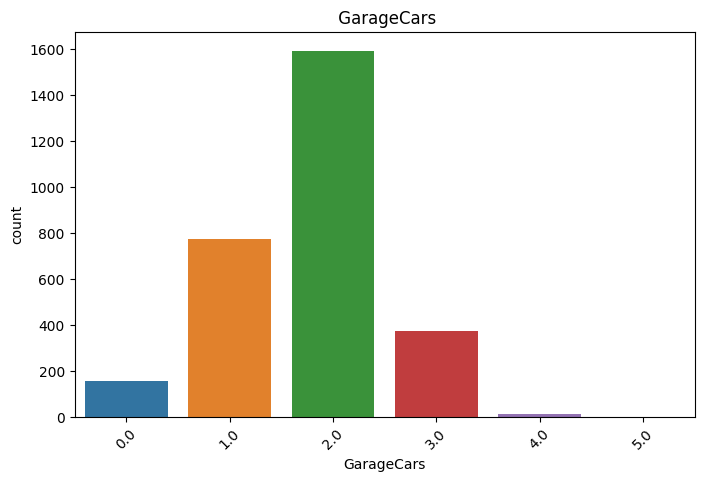

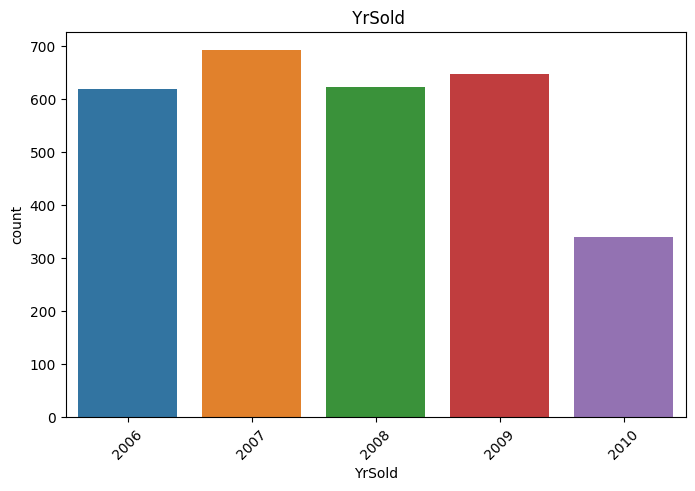

In [7]:

for col in num_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(x=df[col])
    plt.title(f' {col}')
    plt.xticks(rotation=45)
    plt.show()


for col in cat_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df[col])
    plt.title(f' {col}')
    plt.xticks(rotation=45)
    plt.show()

In [8]:

def target(dataframe, target, cat_col):
    print(pd.DataFrame({"Target_Mean": dataframe.groupby(cat_col)[target].mean(),
                        "Count": dataframe[cat_col].value_counts()}),end="\n ###############\n")

for col in cat_cols:
    target(df, "SalePrice", col)



            Target_Mean  Count
MSZoning                      
C (all)    74528.000000     25
FV        214014.061538    139
RH        131558.375000     26
RL        191004.994787   2265
RM        126316.830275    460
 ###############
          Target_Mean  Count
Street                      
Grvl    130190.500000     12
Pave    181130.538514   2907
 ###############
         Target_Mean  Count
Alley                      
Grvl   122219.080000    120
Pave   168000.585366     78
 ###############
            Target_Mean  Count
LotShape                      
IR1       206101.665289    968
IR2       239833.365854     76
IR3       216036.500000     16
Reg       164754.818378   1859
 ###############
               Target_Mean  Count
LandContour                      
Bnk          143104.079365    117
HLS          231533.940000    120
Low          203661.111111     60
Lvl          180183.746758   2622
 ###############
            Target_Mean  Count
Utilities                     
AllPub     180950.

In [9]:

def outlier_thresholds(dataframe,col_name,q1=0.05,q3=0.95): ## Alt ve üst eşik değeri hesaplamak için kullanırız.
    quartile1=dataframe[col_name].quantile(q1) ## Her sütunun çeyreklik değerini belirler.
    quartile3=dataframe[col_name].quantile(q3)
    iqr=quartile3 - quartile1  ## Çeyrekler arası farkı gösterir.
    up_limit=quartile3 + 1.5*iqr  # Üt limiti belirleriz.Bu değerin üstündekiler aykırı değerler.
    low_limit= quartile1 - 1.5 *iqr  #Alt limiti belirleriz. Bu değerin altındaki değerler aykırı değerlerdir.
    return low_limit,up_limit

def check_outlier(dataframe,col_name): #Aykırı değer içerip içermediğini kontrol eder.
    low_limit,up_limit=outlier_thresholds(dataframe,col_name) # Alt ve üst limit değerini alır.
    if dataframe[(dataframe[col_name] >up_limit) | (dataframe[col_name]<low_limit)].any(axis=None):  # ALt limitin altında veya üst limitin üstünde olan değer var mı ona bakar.
        #Eğer var ise true döndürür yok ise false döndürür.
        return True
    else:
        return False

for col in num_cols:
    print(col,":",check_outlier(df,col))

Id : False
MSSubClass : False
LotFrontage : True
LotArea : True
OverallQual : False
YearBuilt : False
YearRemodAdd : False
MasVnrArea : True
BsmtFinSF1 : True
BsmtFinSF2 : True
BsmtUnfSF : False
TotalBsmtSF : True
1stFlrSF : True
2ndFlrSF : False
LowQualFinSF : True
GrLivArea : True
TotRmsAbvGrd : False
GarageYrBlt : True
GarageArea : False
WoodDeckSF : True
OpenPorchSF : True
EnclosedPorch : True
3SsnPorch : True
ScreenPorch : True
PoolArea : True
MiscVal : True
MoSold : False
SalePrice : True


In [10]:

from prettytable import PrettyTable

# PrettyTable ile tablo oluşturma
t = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])

# Her sütun için eksik değerleri kontrol etme
for col in df.columns:
    # NaN değerlerini ve '?' sembolüyle işaretlenen eksik verileri sayma
    missing_count = df[col].isna().sum() + (df[col] == '?').sum()

    # Eksik değer yüzdesi
    missing_percentage = (missing_count / len(df)) * 100

    # Tabloya satır ekleme
    t.add_row([col, missing_count, f"{missing_percentage:.2f}%"])

print(t)


+---------------+----------------+--------------------+
|  Column Name  | Missing Values | Missing Percentage |
+---------------+----------------+--------------------+
|       Id      |       0        |       0.00%        |
|   MSSubClass  |       0        |       0.00%        |
|    MSZoning   |       4        |       0.14%        |
|  LotFrontage  |      486       |       16.65%       |
|    LotArea    |       0        |       0.00%        |
|     Street    |       0        |       0.00%        |
|     Alley     |      2721      |       93.22%       |
|    LotShape   |       0        |       0.00%        |
|  LandContour  |       0        |       0.00%        |
|   Utilities   |       2        |       0.07%        |
|   LotConfig   |       0        |       0.00%        |
|   LandSlope   |       0        |       0.00%        |
|  Neighborhood |       0        |       0.00%        |
|   Condition1  |       0        |       0.00%        |
|   Condition2  |       0        |       0.00%  

In [11]:

# Aykırı değerler için baskılama yöntemi kullanırız.
# Alt ve üst limit belirleyip, bu limit dışındakileri bunlara eşitleriz.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable) #Alt ve üst limiti belirleriz.
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit #Alt limitten düşük olanları alt limete eşitleriz.
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit #Üst limitten büyük olanları üst limite eşitleriz.

for col in num_cols:
    replace_with_thresholds(df,col)

for col in num_cols:
    print(col,":",check_outlier(df,col))



Id : False
MSSubClass : False
LotFrontage : False
LotArea : False
OverallQual : False
YearBuilt : False
YearRemodAdd : False
MasVnrArea : False
BsmtFinSF1 : False
BsmtFinSF2 : False
BsmtUnfSF : False
TotalBsmtSF : False
1stFlrSF : False
2ndFlrSF : False
LowQualFinSF : False
GrLivArea : False
TotRmsAbvGrd : False
GarageYrBlt : False
GarageArea : False
WoodDeckSF : False
OpenPorchSF : False
EnclosedPorch : False
3SsnPorch : False
ScreenPorch : False
PoolArea : False
MiscVal : False
MoSold : False
SalePrice : False


In [12]:


df = df.apply(lambda x: x.fillna(x.mode()[0]) if x.name != 'SalePrice' and x.dtype not in ['object', 'category'] else x, axis=0)
df = df.apply(lambda x: x.fillna(x.mode()[0]) if x.name != 'SalePrice' else x, axis=0)

In [13]:

t2 = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])

# Her sütun için eksik değerleri kontrol etme
for col in df.columns:
    # NaN değerlerini ve '?' sembolüyle işaretlenen eksik verileri sayma
    missing_count = df[col].isna().sum() + (df[col] == '?').sum()

    # Eksik değer yüzdesi
    missing_percentage = (missing_count / len(df)) * 100

    # Tabloya satır ekleme
    t2.add_row([col, missing_count, f"{missing_percentage:.2f}%"])

print(t2)


+---------------+----------------+--------------------+
|  Column Name  | Missing Values | Missing Percentage |
+---------------+----------------+--------------------+
|       Id      |       0        |       0.00%        |
|   MSSubClass  |       0        |       0.00%        |
|    MSZoning   |       0        |       0.00%        |
|  LotFrontage  |       0        |       0.00%        |
|    LotArea    |       0        |       0.00%        |
|     Street    |       0        |       0.00%        |
|     Alley     |       0        |       0.00%        |
|    LotShape   |       0        |       0.00%        |
|  LandContour  |       0        |       0.00%        |
|   Utilities   |       0        |       0.00%        |
|   LotConfig   |       0        |       0.00%        |
|   LandSlope   |       0        |       0.00%        |
|  Neighborhood |       0        |       0.00%        |
|   Condition1  |       0        |       0.00%        |
|   Condition2  |       0        |       0.00%  

          Count      Ratio
MSZoning                  
RL         2269  77.732100
RM          460  15.758822
FV          139   4.761905
RH           26   0.890716
C (all)      25   0.856458
##########################################


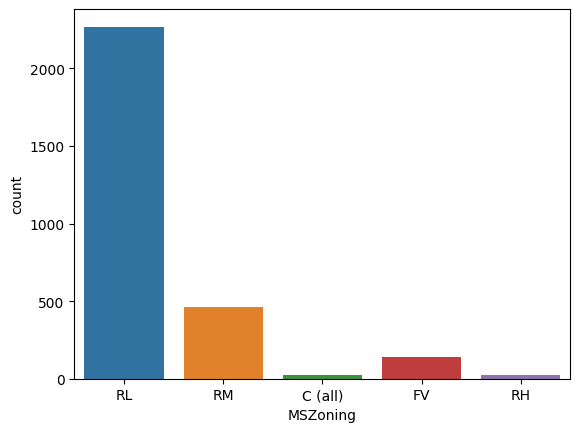

        Count    Ratio
Street                
Pave     2907  99.5889
Grvl       12   0.4111
##########################################


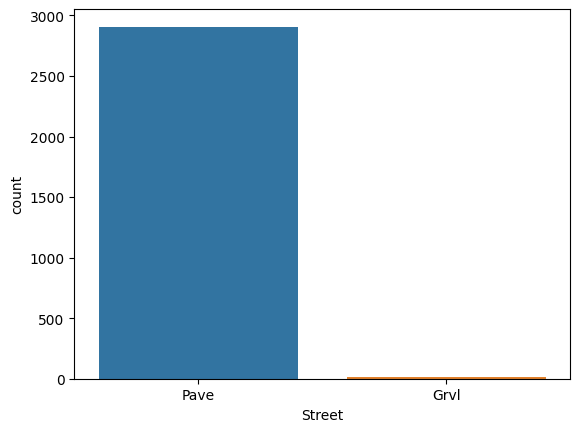

       Count      Ratio
Alley                  
Grvl    2841  97.327852
Pave      78   2.672148
##########################################


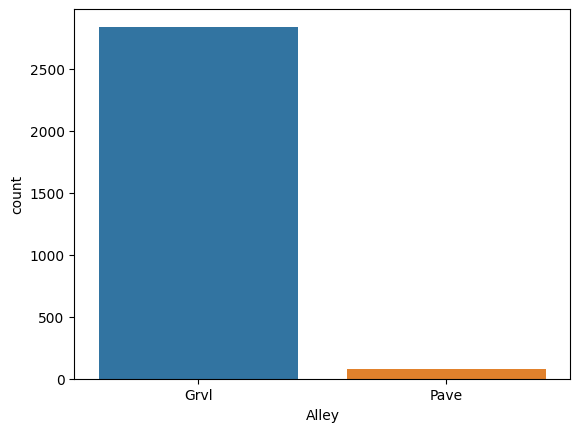

          Count      Ratio
LotShape                  
Reg        1859  63.686194
IR1         968  33.162042
IR2          76   2.603631
IR3          16   0.548133
##########################################


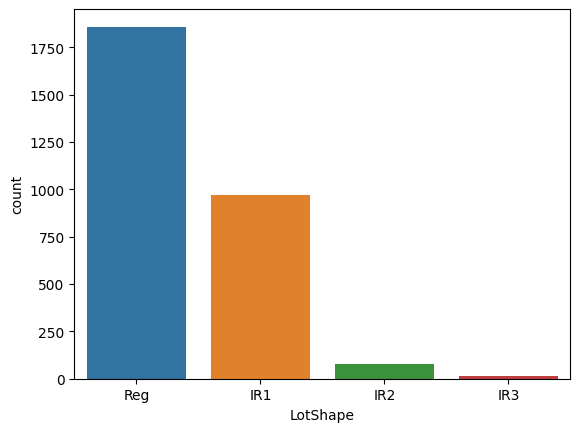

             Count      Ratio
LandContour                  
Lvl           2622  89.825283
HLS            120   4.110997
Bnk            117   4.008222
Low             60   2.055498
##########################################


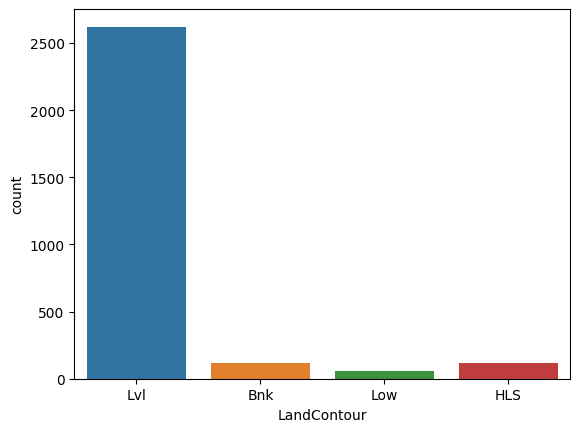

           Count      Ratio
Utilities                  
AllPub      2918  99.965742
NoSeWa         1   0.034258
##########################################


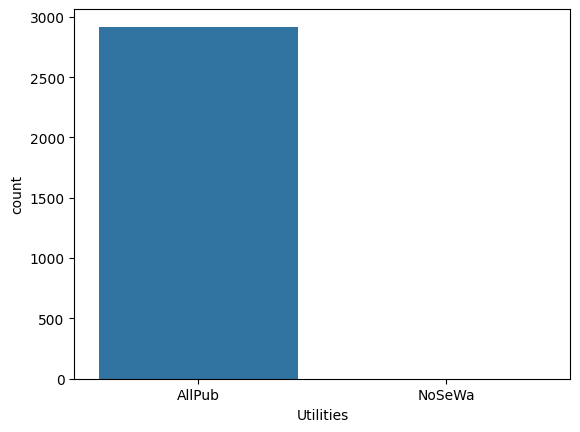

           Count      Ratio
LotConfig                  
Inside      2133  73.072970
Corner       511  17.505995
CulDSac      176   6.029462
FR2           85   2.911956
FR3           14   0.479616
##########################################


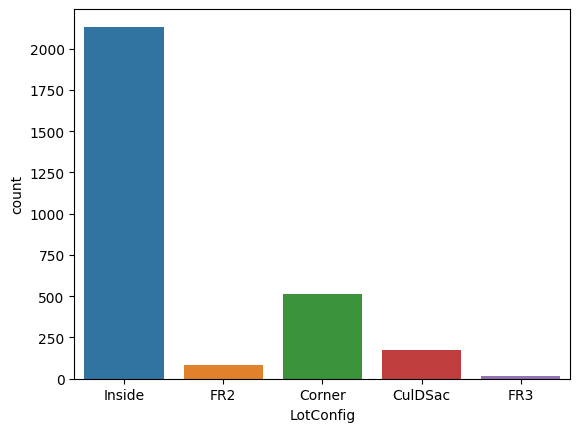

           Count      Ratio
LandSlope                  
Gtl         2778  95.169579
Mod          125   4.282288
Sev           16   0.548133
##########################################


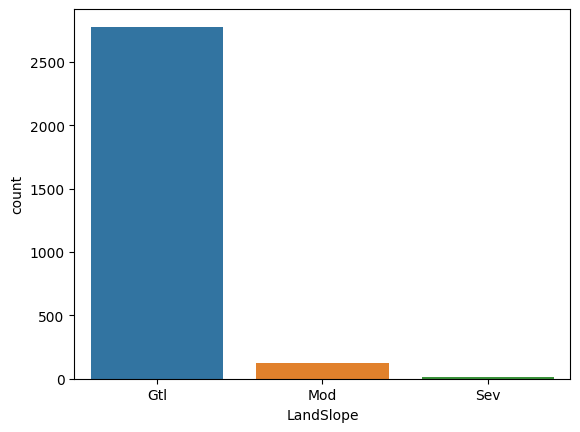

              Count      Ratio
Neighborhood                  
NAmes           443  15.176430
CollgCr         267   9.146968
OldTown         239   8.187736
Edwards         194   6.646112
Somerst         182   6.235012
NridgHt         166   5.686879
Gilbert         165   5.652621
Sawyer          151   5.173004
NWAmes          131   4.487838
SawyerW         125   4.282288
Mitchel         114   3.905447
BrkSide         108   3.699897
Crawfor         103   3.528606
IDOTRR           93   3.186023
Timber           72   2.466598
NoRidge          71   2.432340
StoneBr          51   1.747174
SWISU            48   1.644399
ClearCr          44   1.507366
MeadowV          37   1.267557
BrDale           30   1.027749
Blmngtn          28   0.959233
Veenker          24   0.822199
NPkVill          23   0.787941
Blueste          10   0.342583
##########################################


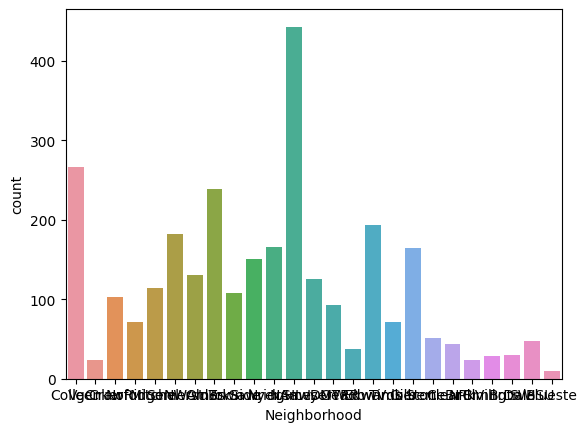

            Count      Ratio
Condition1                  
Norm         2511  86.022610
Feedr         164   5.618362
Artery         92   3.151764
RRAn           50   1.712915
PosN           39   1.336074
RRAe           28   0.959233
PosA           20   0.685166
RRNn            9   0.308325
RRNe            6   0.205550
##########################################


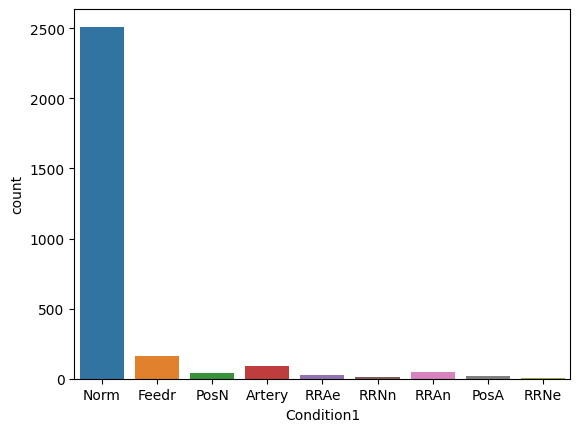

            Count      Ratio
Condition2                  
Norm         2889  98.972251
Feedr          13   0.445358
Artery          5   0.171292
PosN            4   0.137033
PosA            4   0.137033
RRNn            2   0.068517
RRAn            1   0.034258
RRAe            1   0.034258
##########################################


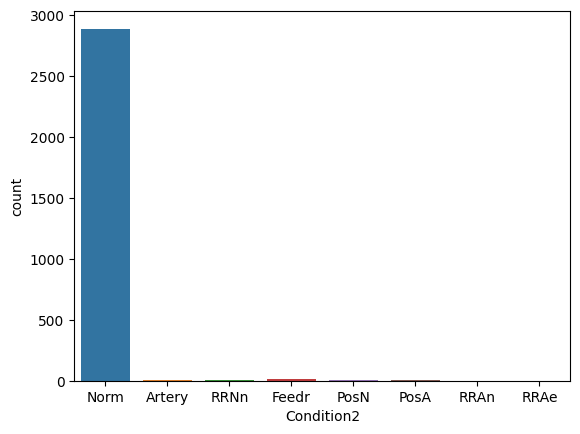

          Count      Ratio
BldgType                  
1Fam       2425  83.076396
TwnhsE      227   7.776636
Duplex      109   3.734156
Twnhs        96   3.288798
2fmCon       62   2.124015
##########################################


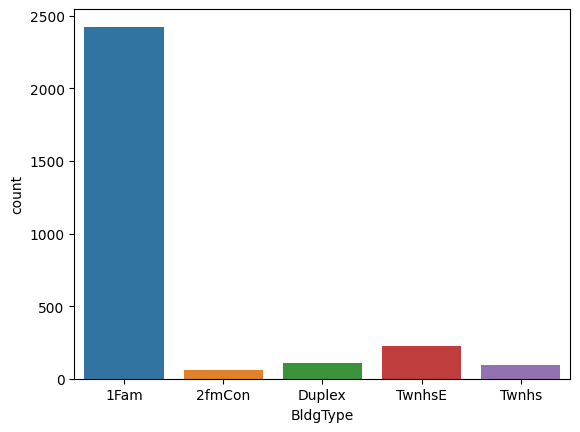

            Count      Ratio
HouseStyle                  
1Story       1471  50.393971
2Story        872  29.873244
1.5Fin        314  10.757109
SLvl          128   4.385063
SFoyer         83   2.843440
2.5Unf         24   0.822199
1.5Unf         19   0.650908
2.5Fin          8   0.274066
##########################################


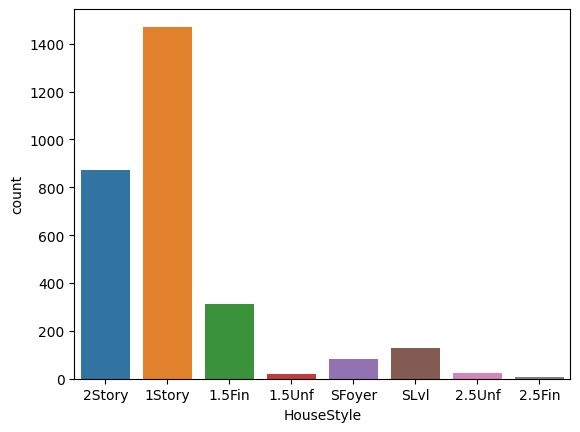

           Count      Ratio
RoofStyle                  
Gable       2310  79.136691
Hip          551  18.876328
Gambrel       22   0.753683
Flat          20   0.685166
Mansard       11   0.376841
Shed           5   0.171292
##########################################


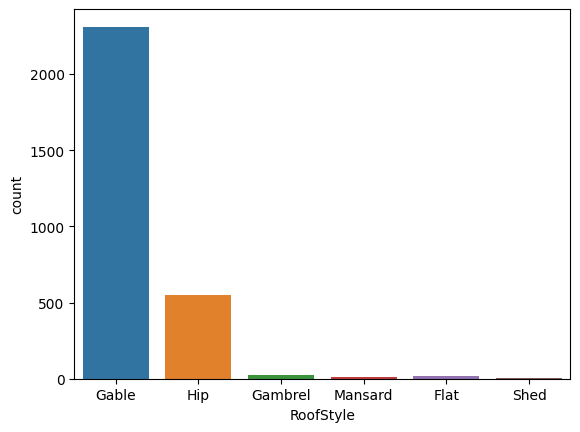

          Count      Ratio
RoofMatl                  
CompShg    2876  98.526893
Tar&Grv      23   0.787941
WdShake       9   0.308325
WdShngl       7   0.239808
Metal         1   0.034258
Membran       1   0.034258
Roll          1   0.034258
ClyTile       1   0.034258
##########################################


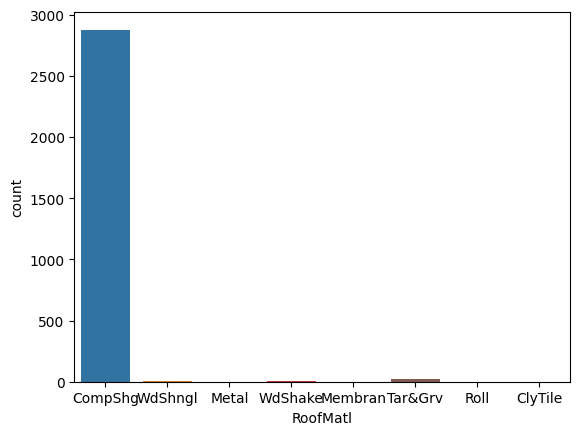

             Count      Ratio
Exterior1st                  
VinylSd       1026  35.149024
MetalSd        450  15.416238
HdBoard        442  15.142172
Wd Sdng        411  14.080164
Plywood        221   7.571086
CemntBd        126   4.316547
BrkFace         87   2.980473
WdShing         56   1.918465
AsbShng         44   1.507366
Stucco          43   1.473107
BrkComm          6   0.205550
AsphShn          2   0.068517
Stone            2   0.068517
CBlock           2   0.068517
ImStucc          1   0.034258
##########################################


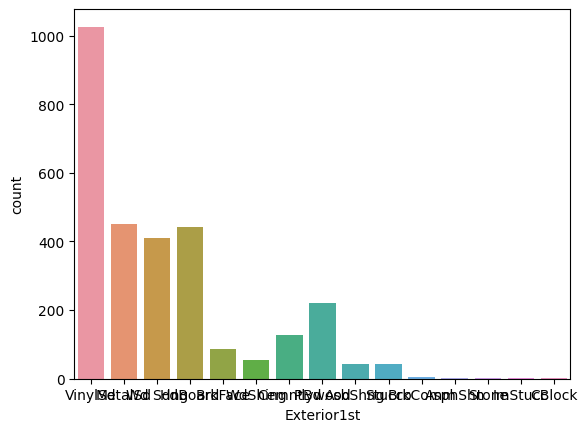

             Count      Ratio
Exterior2nd                  
VinylSd       1015  34.772182
MetalSd        447  15.313464
HdBoard        406  13.908873
Wd Sdng        391  13.394998
Plywood        270   9.249743
CmentBd        126   4.316547
Wd Shng         81   2.774923
BrkFace         47   1.610140
Stucco          47   1.610140
AsbShng         38   1.301816
Brk Cmn         22   0.753683
ImStucc         15   0.513875
Stone            6   0.205550
AsphShn          4   0.137033
CBlock           3   0.102775
Other            1   0.034258
##########################################


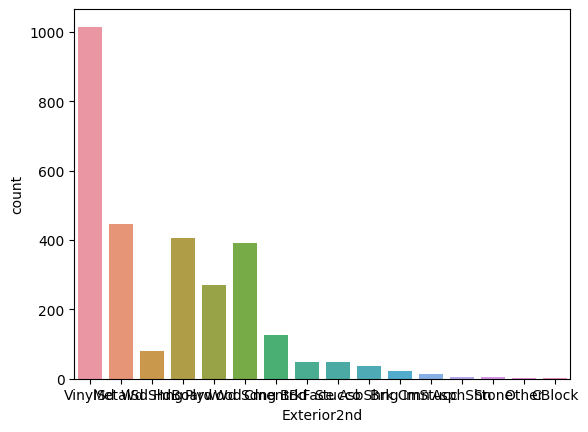

            Count      Ratio
MasVnrType                  
BrkFace      2645  90.613224
Stone         249   8.530319
BrkCmn         25   0.856458
##########################################


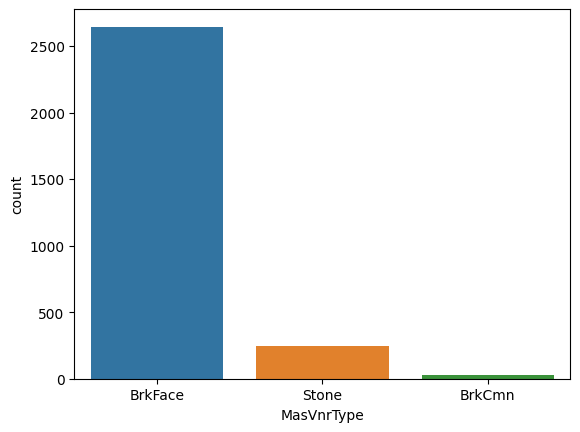

           Count      Ratio
ExterQual                  
TA          1798  61.596437
Gd           979  33.538883
Ex           107   3.665639
Fa            35   1.199041
##########################################


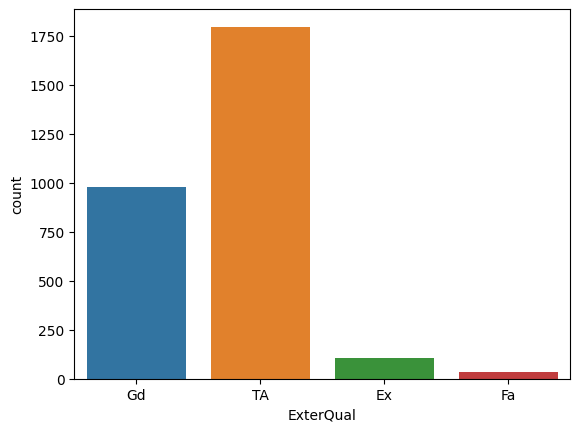

           Count      Ratio
ExterCond                  
TA          2538  86.947585
Gd           299  10.243234
Fa            67   2.295307
Ex            12   0.411100
Po             3   0.102775
##########################################


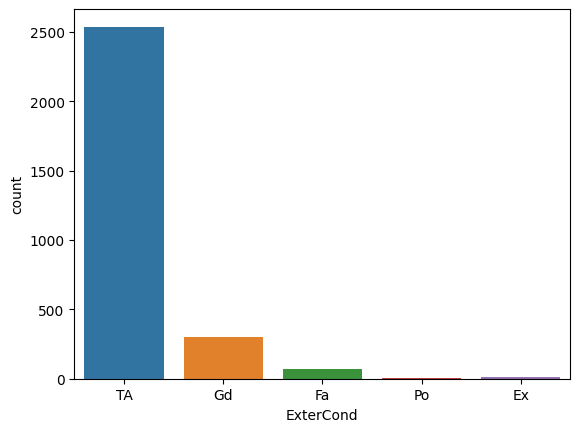

            Count      Ratio
Foundation                  
PConc        1308  44.809866
CBlock       1235  42.309010
BrkTil        311  10.654334
Slab           49   1.678657
Stone          11   0.376841
Wood            5   0.171292
##########################################


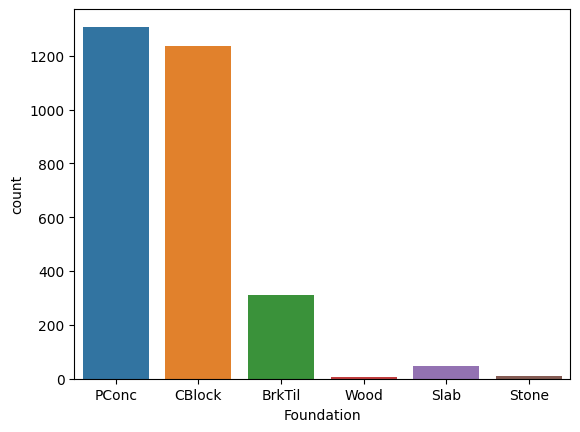

          Count      Ratio
BsmtQual                  
TA         1364  46.728332
Gd         1209  41.418294
Ex          258   8.838643
Fa           88   3.014731
##########################################


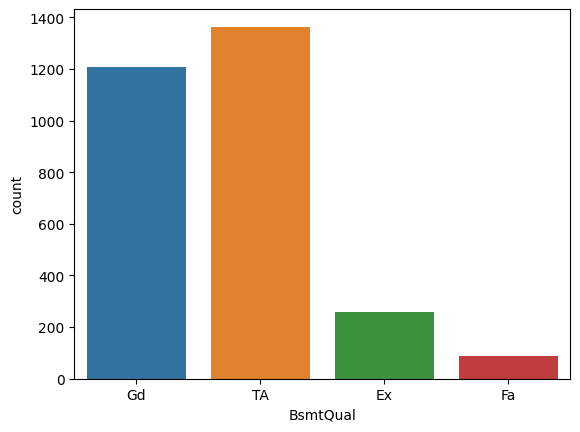

          Count      Ratio
BsmtCond                  
TA         2688  92.086331
Gd          122   4.179514
Fa          104   3.562864
Po            5   0.171292
##########################################


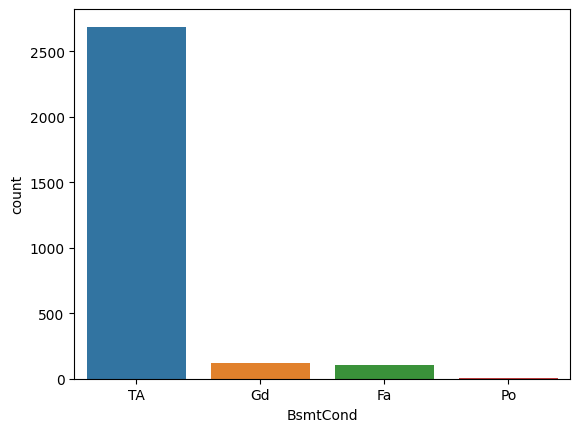

              Count      Ratio
BsmtExposure                  
No             1986  68.036999
Av              418  14.319973
Gd              276   9.455293
Mn              239   8.187736
##########################################


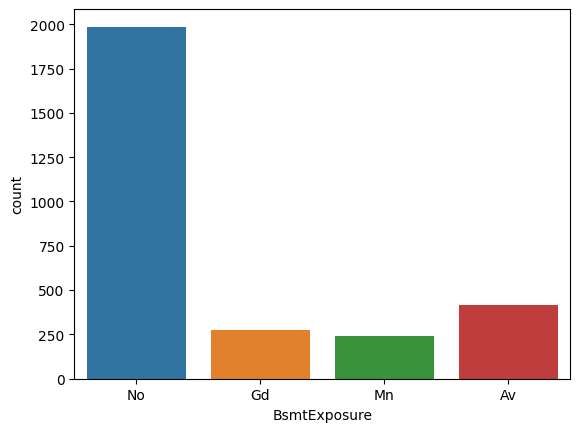

              Count      Ratio
BsmtFinType1                  
Unf             930  31.860226
GLQ             849  29.085303
ALQ             429  14.696814
Rec             288   9.866393
BLQ             269   9.215485
LwQ             154   5.275779
##########################################


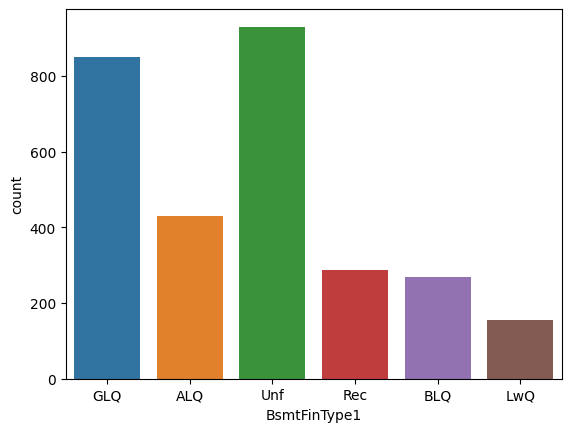

              Count      Ratio
BsmtFinType2                  
Unf            2573  88.146626
Rec             105   3.597122
LwQ              87   2.980473
BLQ              68   2.329565
ALQ              52   1.781432
GLQ              34   1.164782
##########################################


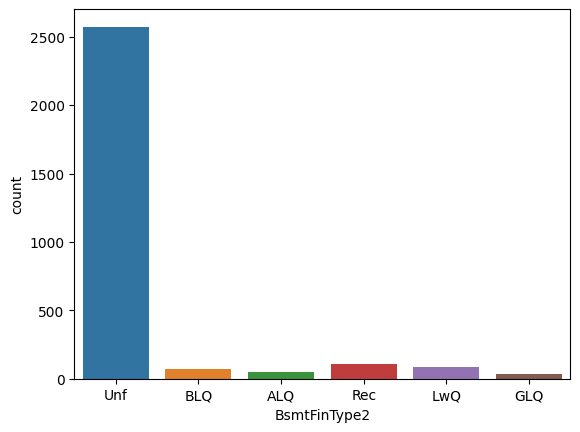

         Count      Ratio
Heating                  
GasA      2874  98.458376
GasW        27   0.924974
Grav         9   0.308325
Wall         6   0.205550
OthW         2   0.068517
Floor        1   0.034258
##########################################


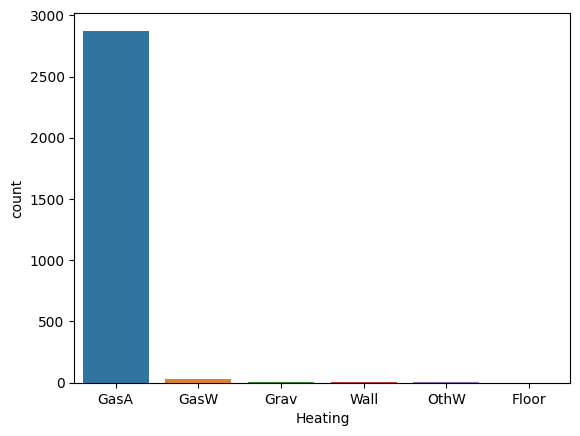

           Count      Ratio
HeatingQC                  
Ex          1493  51.147653
TA           857  29.359370
Gd           474  16.238438
Fa            92   3.151764
Po             3   0.102775
##########################################


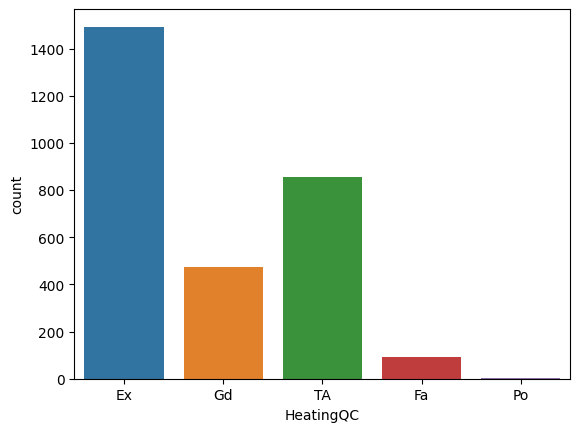

            Count      Ratio
CentralAir                  
Y            2723  93.285372
N             196   6.714628
##########################################


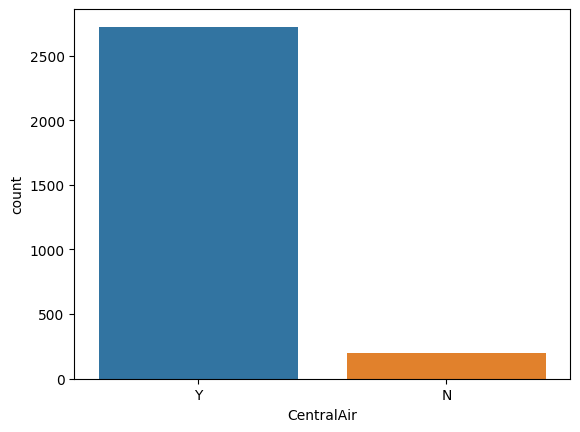

            Count      Ratio
Electrical                  
SBrkr        2672  91.538198
FuseA         188   6.440562
FuseF          50   1.712915
FuseP           8   0.274066
Mix             1   0.034258
##########################################


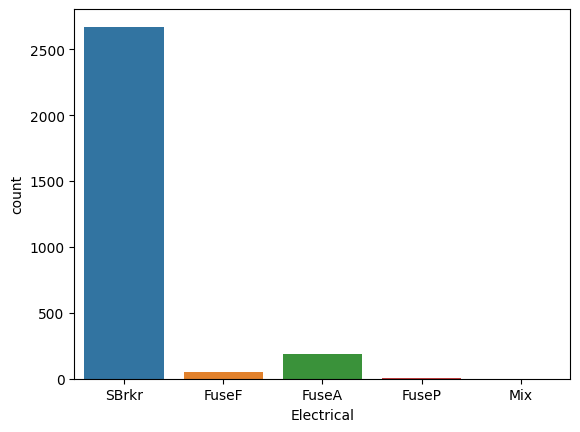

             Count      Ratio
KitchenQual                  
TA            1493  51.147653
Gd            1151  39.431312
Ex             205   7.022953
Fa              70   2.398082
##########################################


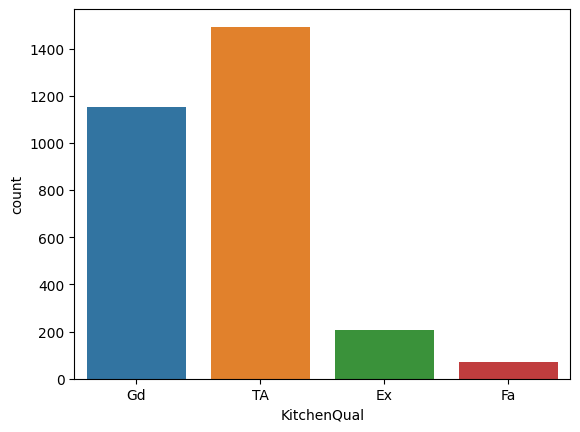

            Count      Ratio
Functional                  
Typ          2719  93.148338
Min2           70   2.398082
Min1           65   2.226790
Mod            35   1.199041
Maj1           19   0.650908
Maj2            9   0.308325
Sev             2   0.068517
##########################################


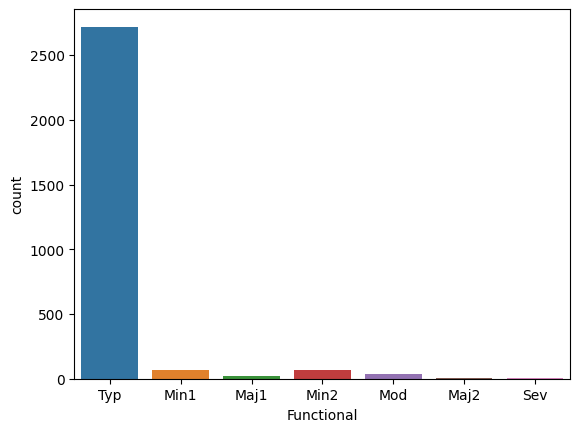

             Count      Ratio
FireplaceQu                  
Gd            2164  74.134978
TA             592  20.280918
Fa              74   2.535115
Po              46   1.575882
Ex              43   1.473107
##########################################


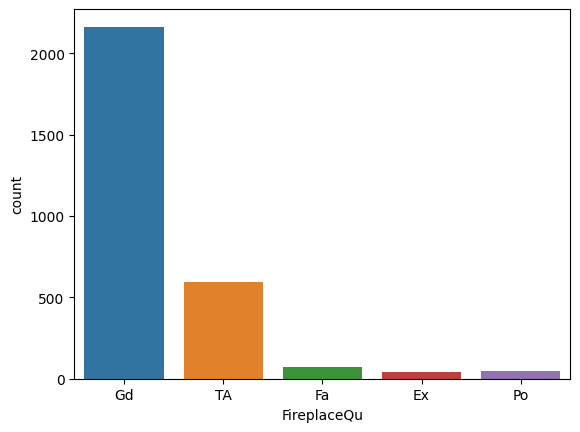

            Count      Ratio
GarageType                  
Attchd       1880  64.405618
Detchd        779  26.687222
BuiltIn       186   6.372045
Basment        36   1.233299
2Types         23   0.787941
CarPort        15   0.513875
##########################################


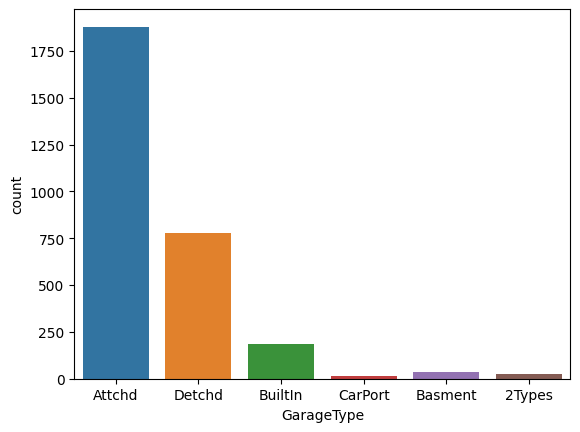

              Count      Ratio
GarageFinish                  
Unf            1389  47.584789
RFn             811  27.783487
Fin             719  24.631723
##########################################


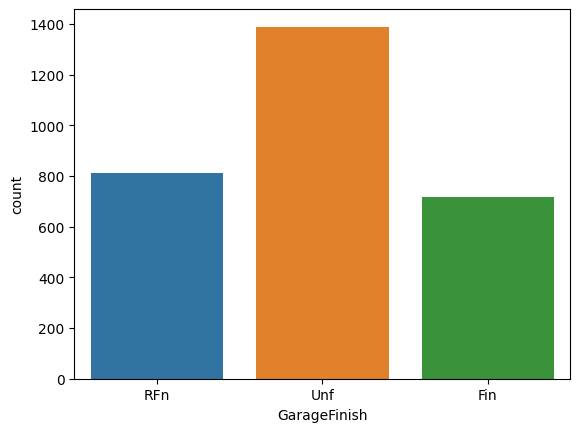

            Count      Ratio
GarageQual                  
TA           2763  94.655704
Fa            124   4.248030
Gd             24   0.822199
Po              5   0.171292
Ex              3   0.102775
##########################################


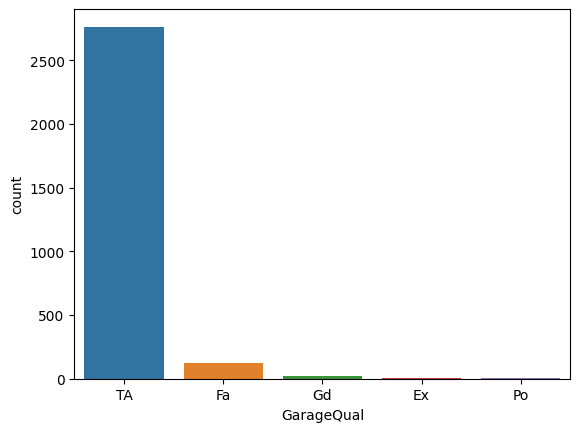

            Count      Ratio
GarageCond                  
TA           2813  96.368619
Fa             74   2.535115
Gd             15   0.513875
Po             14   0.479616
Ex              3   0.102775
##########################################


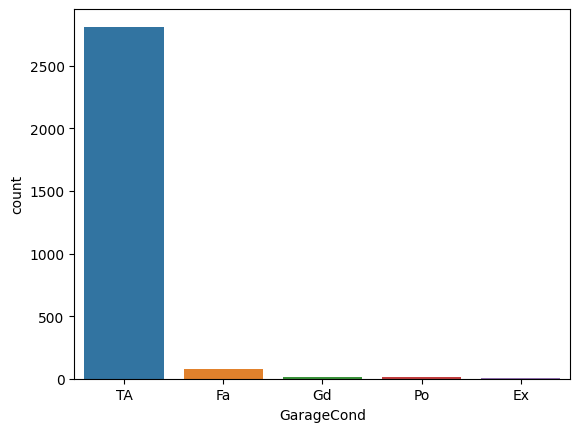

            Count      Ratio
PavedDrive                  
Y            2641  90.476190
N             216   7.399794
P              62   2.124015
##########################################


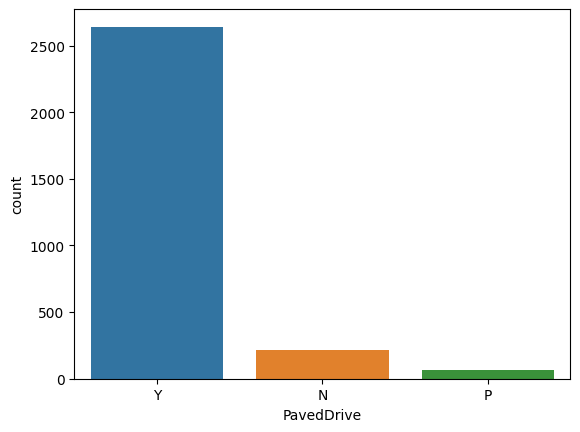

        Count      Ratio
PoolQC                  
Ex       2913  99.794450
Gd          4   0.137033
Fa          2   0.068517
##########################################


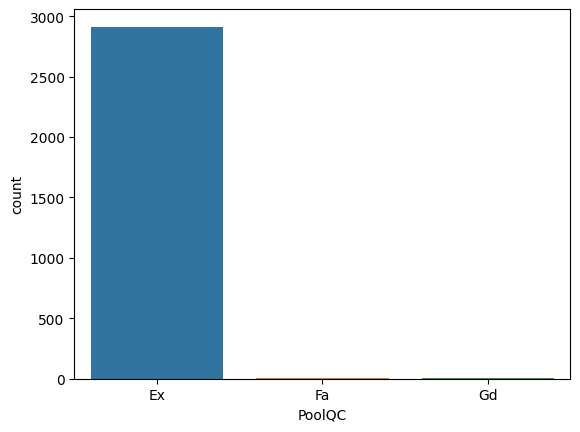

       Count     Ratio
Fence                 
MnPrv   2677  91.70949
GdPrv    118   4.04248
GdWo     112   3.83693
MnWw      12   0.41110
##########################################


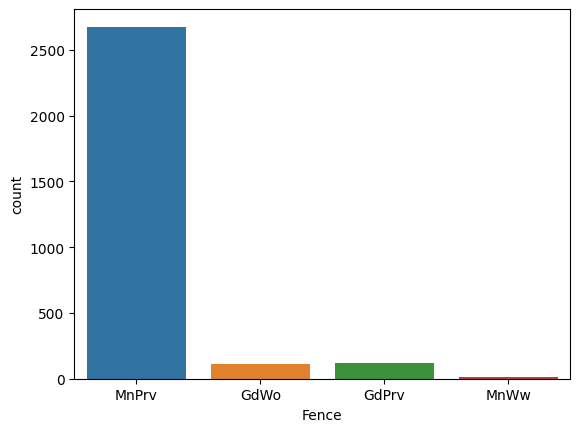

             Count      Ratio
MiscFeature                  
Shed          2909  99.657417
Gar2             5   0.171292
Othr             4   0.137033
TenC             1   0.034258
##########################################


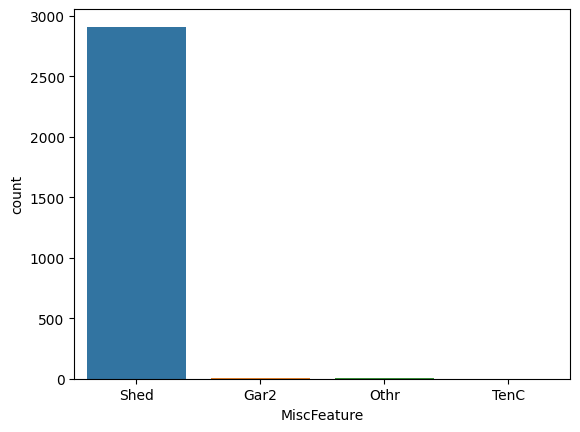

          Count      Ratio
SaleType                  
WD         2526  86.536485
New         239   8.187736
COD          87   2.980473
ConLD        26   0.890716
CWD          12   0.411100
ConLI         9   0.308325
ConLw         8   0.274066
Oth           7   0.239808
Con           5   0.171292
##########################################


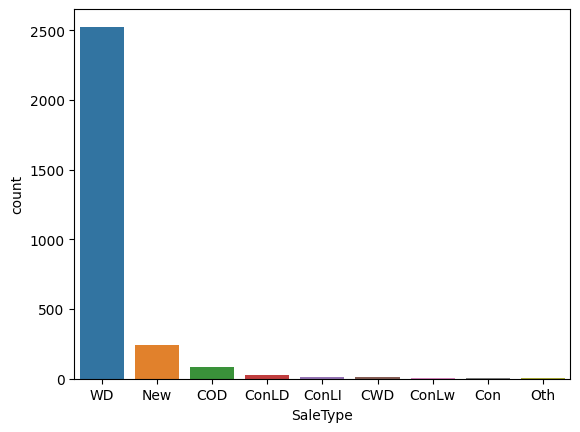

               Count      Ratio
SaleCondition                  
Normal          2402  82.288455
Partial          245   8.393285
Abnorml          190   6.509078
Family            46   1.575882
Alloca            24   0.822199
AdjLand           12   0.411100
##########################################


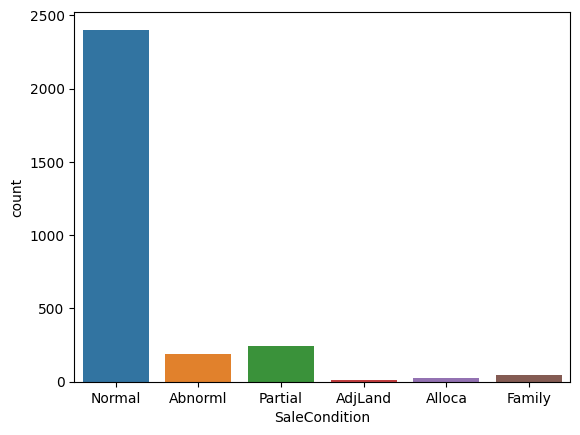

             Count      Ratio
OverallCond                  
5             1645  56.354916
6              531  18.191161
7              390  13.360740
8              144   4.933196
4              101   3.460089
3               50   1.712915
9               41   1.404591
2               10   0.342583
1                7   0.239808
##########################################


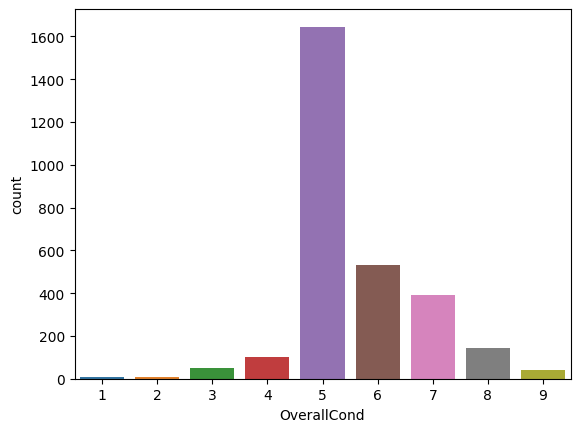

              Count      Ratio
BsmtFullBath                  
0.0            1707  58.478931
1.0            1172  40.150737
2.0              38   1.301816
3.0               2   0.068517
##########################################


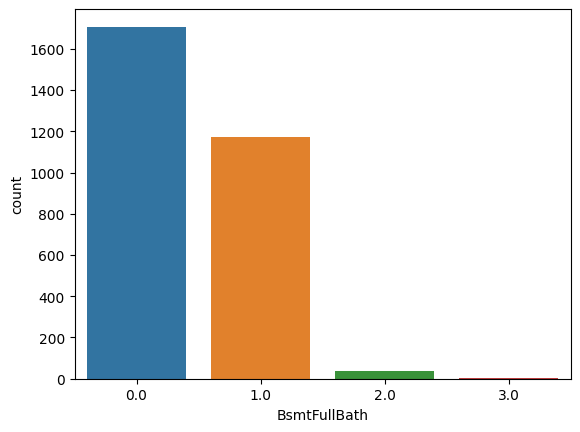

              Count      Ratio
BsmtHalfBath                  
0.0            2744  94.004796
1.0             171   5.858171
2.0               4   0.137033
##########################################


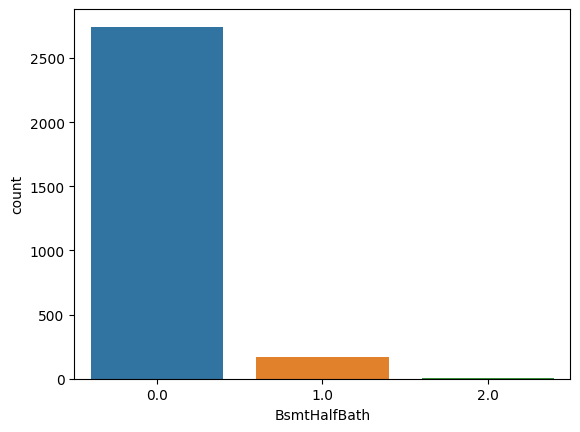

          Count      Ratio
FullBath                  
2          1530  52.415211
1          1309  44.844125
3            64   2.192532
0            12   0.411100
4             4   0.137033
##########################################


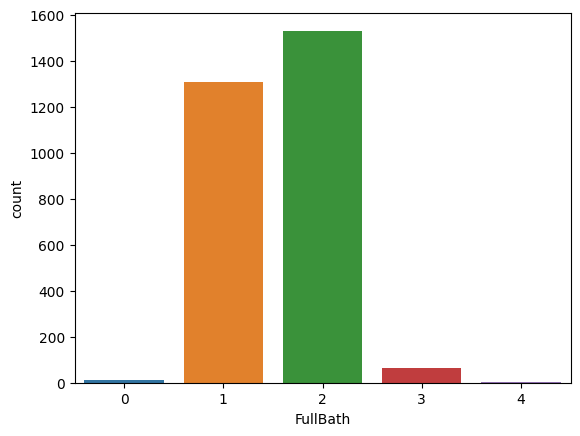

          Count      Ratio
HalfBath                  
0          1834  62.829736
1          1060  36.313806
2            25   0.856458
##########################################


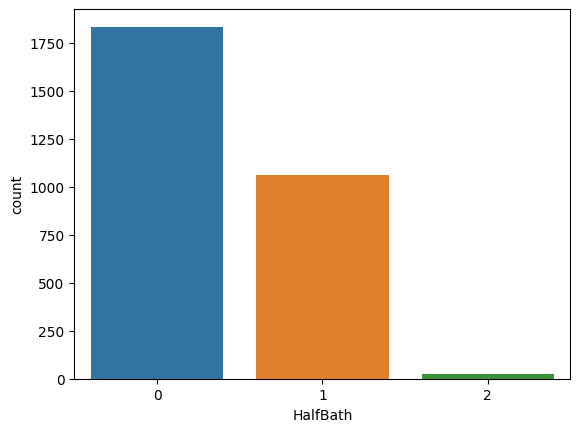

              Count      Ratio
BedroomAbvGr                  
3              1596  54.676259
2               742  25.419664
4               400  13.703323
1               103   3.528606
5                48   1.644399
6                21   0.719424
0                 8   0.274066
8                 1   0.034258
##########################################


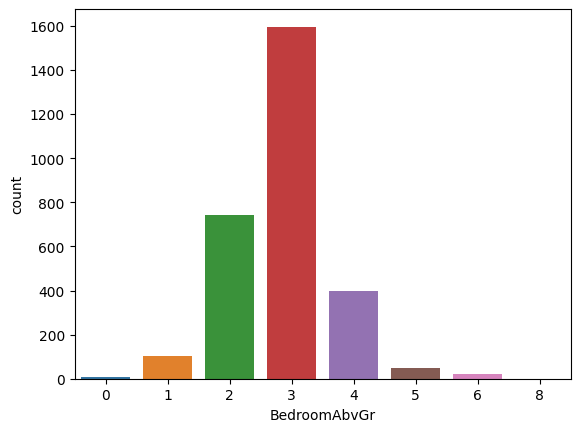

              Count      Ratio
KitchenAbvGr                  
1              2785  95.409387
2               129   4.419322
0                 3   0.102775
3                 2   0.068517
##########################################


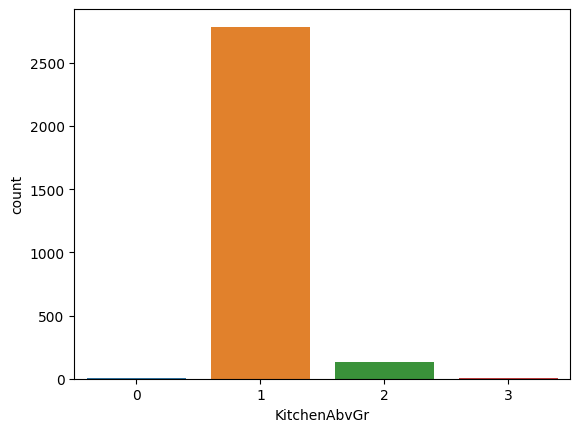

            Count      Ratio
Fireplaces                  
0            1420  48.646797
1            1268  43.439534
2             219   7.502569
3              11   0.376841
4               1   0.034258
##########################################


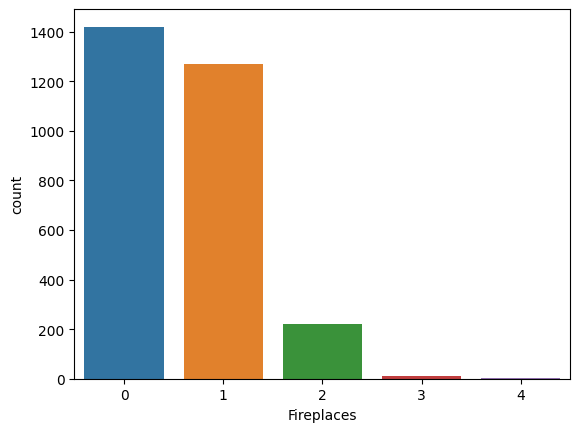

            Count      Ratio
GarageCars                  
2.0          1595  54.642001
1.0           776  26.584447
3.0           374  12.812607
0.0           157   5.378554
4.0            16   0.548133
5.0             1   0.034258
##########################################


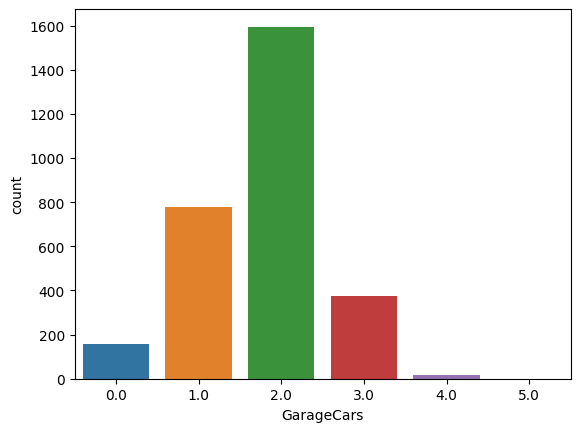

        Count      Ratio
YrSold                  
2007      692  23.706749
2009      647  22.165125
2008      622  21.308667
2006      619  21.205892
2010      339  11.613566
##########################################


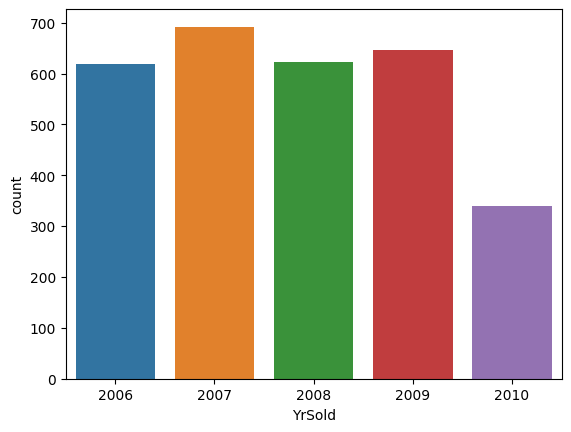

MSZoning : 5
          COUNT     RATIO    TARGET_MEAN
MSZoning                                
C (all)      25  0.008565   74528.000000
FV          139  0.047619  214014.061538
RH           26  0.008907  131558.375000
RL         2269  0.777321  190889.008688
RM          460  0.157588  126316.830275


Street : 2
        COUNT     RATIO    TARGET_MEAN
Street                                
Grvl       12  0.004111  130190.500000
Pave     2907  0.995889  181038.722834


Alley : 2
       COUNT     RATIO    TARGET_MEAN
Alley                                
Grvl    2841  0.973279  181200.438337
Pave      78  0.026721  168000.585366


LotShape : 4
          COUNT     RATIO    TARGET_MEAN
LotShape                                
IR1         968  0.331620  205825.838843
IR2          76  0.026036  239833.365854
IR3          16  0.005481  216036.500000
Reg        1859  0.636862  164754.818378


LandContour : 4
             COUNT     RATIO    TARGET_MEAN
LandContour                                


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,60,RL,65.0,8450.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0,1710.0,1.0,0.0,2,1,3,1,Gd,8.0,Typ,0,Gd,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61.0,0,0,0.0,0,Ex,MnPrv,Shed,0,2.0,2008,WD,Normal,208500.0
1,2.0,20,RL,80.0,9600.0,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,Rare,Feedr,Norm,1Fam,1Story,6,8,1976,1976.0,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0,1262.0,0.0,1.0,2,0,3,1,TA,6.0,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0.0,0,0,0.0,0,Ex,MnPrv,Shed,0,5.0,2007,WD,Normal,181500.0
2,3.0,60,RL,68.0,11250.0,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0,1786.0,1.0,0.0,2,1,3,1,Gd,6.0,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42.0,0,0,0.0,0,Ex,MnPrv,Shed,0,9.0,2008,WD,Normal,223500.0
3,4.0,70,RL,60.0,9550.0,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,BrkFace,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0,1717.0,1.0,0.0,1,0,3,1,Gd,7.0,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35.0,272,0,0.0,0,Ex,MnPrv,Shed,0,2.0,2006,WD,Abnorml,140000.0
4,5.0,60,RL,84.0,14260.0,Pave,Grvl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0,2198.0,1.0,0.0,2,1,4,1,Gd,9.0,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84.0,0,0,0.0,0,Ex,MnPrv,Shed,0,12.0,2008,WD,Normal,250000.0


In [14]:



import seaborn as sns
from matplotlib import pyplot as plt

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({"Count": dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df,col,plot=True)


def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "SalePrice", cat_cols)

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

df= rare_encoder(df, 0.01)

df.head()

In [15]:

df['Age'] = df['YrSold'] - df['YearBuilt']


In [16]:


def label_encoder(dataframe, binary_cols):
    labelencoder = LabelEncoder()
    for binary_col in binary_cols:
        dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype == "o" and df[col].nunique() == 2]
for col in binary_cols:
    df = label_encoder(df, col)
df.head()
df.info()
cat_cols, num_cols,cat_but_car,num_but_cat = grab_col_names(df)


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


df2= one_hot_encoder(df,cat_cols)
df2.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   float64
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   float64
 5   Street         2919 non-null   object 
 6   Alley          2919 non-null   object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2919 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,SalePrice,Age,MSZoning_FV,MSZoning_RL,MSZoning_RM,MSZoning_Rare,Street_Pave,Street_Rare,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_Rare,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_Rare,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_Inside,LotConfig_Rare,LandSlope_Gtl,LandSlope_Mod,LandSlope_Rare,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Rare,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition1_RRAn,Condition1_Rare,Condition2_Norm,Condition2_Rare,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Rare,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Rare,RoofMatl_CompShg,RoofMatl_Rare,Exterior1st_AsbShng,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Rare,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Rare,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Rare,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Rare,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Rare,Foundation_Slab,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Rare,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_Rare,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Rare,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_Rare,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Rare,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_Detchd,GarageType_Rare,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Rare,GarageQual_TA,GarageCond_Fa,GarageCond_Rare,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Rare,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_Rare,MiscFeature_Rare,MiscFeature_Shed,SaleType_COD,SaleType_New,SaleType_Rare,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Rare,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,LowQualFinSF_0,BsmtFullBath_0.0,BsmtFullBath_1.0,BsmtFullBath_2.0,BsmtFullBath_3.0,BsmtHalfBath_0.0,BsmtHalfBath_1.0,BsmtHalfBath_2.0,FullBath_0,FullBath_1,FullBath_2,FullBath_3,FullBath_4,HalfBath_0,HalfBath_1,HalfBath_2,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8,KitchenAbvGr_0,KitchenAbvGr_1,KitchenAbvGr_2,KitchenAbvGr_3,Fireplaces_0,Fireplaces_1,Fireplaces_2,

In [17]:

train_df = df2[df2['SalePrice'].notnull()]
test_df = df2[df2['SalePrice'].isnull()]

y = np.log1p(train_df['SalePrice'])
X = train_df.drop(["Id", "SalePrice"], axis=1)


In [18]:

## Linear Regression ##

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg_model = LinearRegression().fit(X_train,y_train)
reg_pred = reg_model.predict(X_test)
y_test_or = np.expm1(y_test)
reg_pred_or=np.expm1(reg_pred)
actual=pd.DataFrame({"Sonuç":y_test_or,"Tahmin":reg_pred_or})

print('MAE:', mean_absolute_error(y_test, reg_pred))
print('MSE:', mean_squared_error(y_test, reg_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, reg_pred)))

print(reg_model.score(X_test,y_test))
#R², modelin bağımlı değişkenin varyansını ne kadar açıkladığını gösteren bir ölçüdür.
# R² değeri 1'e ne kadar yakınsa, modelin veriyi o kadar iyi açıkladığı anlamına gelir.

np.mean(np.sqrt(-cross_val_score(reg_model,
                                 X_train,
                                 y_train,
                                 cv=5,
                                 scoring="neg_mean_squared_error")))






MAE: 0.11046797565030714
MSE: 0.06903725337563303
RMSE: 0.26274941175125976
0.5914297929958066


0.1743110096364272

In [19]:

##  Random Forest ##
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()
rf.get_params()
rf.fit(X_train,y_train)
y_pred_rf=rf.predict(X_test)
actual_rf=pd.DataFrame({"Sonuç":y_test,"Tahmin":y_pred_rf})
print(actual)

print(mean_squared_error(y_test,y_pred_rf))
print(mean_absolute_error(y_test,y_pred_rf))
print(np.sqrt(mean_squared_error(y_test,y_pred_rf)))
print(rf.score(X_test,y_test))

cv_results = cross_validate(rf, X_train, y_train, cv=10, scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"])
mae = -cv_results['test_neg_mean_absolute_error'].mean()  # Negatif olduğu için
mse = -cv_results['test_neg_mean_squared_error'].mean()  # Negatif olduğu için
mean_r2 = cv_results['test_r2'].mean()

# Hiperparametre Ayarı


rf_params = {"max_depth": [5, 8, None],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}

#
rf_best_grid = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1, verbose=False).fit(X_train, y_train)
rf_best_grid.best_params_

rf_final = rf.set_params(**rf_best_grid.best_params_, random_state=33).fit(X_train, y_train)
cv_results = cross_validate(rf_final, X_train, y_train, cv=10, scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"])
mae_rf = -cv_results['test_neg_mean_absolute_error'].mean()  # Negatif olduğu için
mse_rf = -cv_results['test_neg_mean_squared_error'].mean()  # Negatif olduğu için
mean_r2_rf = cv_results['test_r2'].mean()
print("MAE:",mae_rf)
print("MSE",mse_rf)
print("R2",mean_r2_rf)

         Sonuç         Tahmin
892   154500.0  153163.467455
1105  325000.0  362373.764793
413   115000.0  100821.203927
522   159000.0  177257.882003
1036  315500.0  324057.843969
...        ...            ...
331   139000.0  134073.867631
323   126175.0  124074.718895
650   205950.0  209312.568987
439   110000.0  139398.447765
798   485000.0  436409.538185

[438 rows x 2 columns]
0.019460326289199956
0.09498158037648718
0.1395002734377247
0.8848316068270196
MAE: 0.10155126464800643
MSE 0.02308318799841575
R2 0.8500196878837682


In [20]:

### Xgboost

from xgboost.sklearn import XGBRFRegressor
xgb=XGBRFRegressor()
xgb.get_params()
xgb.fit(X_train,y_train)
y_pred_xgb=xgb.predict(X_test)
actual_xgb=pd.DataFrame({"Sonuç":y_test,"Tahmin":y_pred_xgb})
print(actual)

print(mean_squared_error(y_test,y_pred_xgb))
print(mean_absolute_error(y_test,y_pred_xgb))
print(np.sqrt(mean_squared_error(y_test,y_pred_xgb)))
print(xgb.score(X_test,y_test))

##Hiperparametre Ayarları
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.7, 1]}


xgboost_best_grid = GridSearchCV(xgb, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)

xgboost_best_grid.best_params_
xgb_final = xgb.set_params(**xgboost_best_grid.best_params_, random_state=33).fit(X_train, y_train)
cv_results_xgb = cross_validate(xgb_final, X_train, y_train, cv=10, scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"])

mae_xgb = -cv_results_xgb['test_neg_mean_absolute_error'].mean()  # Negatif olduğu için
mse_xgb = -cv_results_xgb['test_neg_mean_squared_error'].mean()  # Negatif olduğu için
mean_r2_xgb = cv_results_xgb['test_r2'].mean()
print("MAE:",mae_xgb)
print("MSE",mse_xgb)
print("R2",mean_r2_xgb)

         Sonuç         Tahmin
892   154500.0  153163.467455
1105  325000.0  362373.764793
413   115000.0  100821.203927
522   159000.0  177257.882003
1036  315500.0  324057.843969
...        ...            ...
331   139000.0  134073.867631
323   126175.0  124074.718895
650   205950.0  209312.568987
439   110000.0  139398.447765
798   485000.0  436409.538185

[438 rows x 2 columns]
0.022961573955994304
0.10598388071065777
0.15153076900746695
0.8641108305207591
Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAE: 0.28057268295446536
MSE 0.13137721838458005
R2 0.14757150929653567


In [21]:

###Catboost
from catboost import CatBoostRegressor

cbost=CatBoostRegressor(random_state=17, verbose=False)
cbost.get_params()
cbost.fit(X_train,y_train,verbose=False)
y_pred_cbost=cbost.predict(X_test)
actual_cbost=pd.DataFrame({"Sonuç":y_test,"Tahmin":y_pred_cbost})
print(actual_cbost)

print(mean_squared_error(y_test,y_pred_cbost))
print(mean_absolute_error(y_test,y_pred_cbost))
print(np.sqrt(mean_squared_error(y_test,y_pred_cbost)))
print(cbost.score(X_test,y_test))


cbost_params = {
                'learning_rate': [0.01,  0.1],
                'depth': [4, 6,8],
                'iterations': [100, 200, 300]
}


# GridSearchCV ile en iyi parametreleri bulma
catboost_best_grid = GridSearchCV(cbost, cbost_params, cv=5, n_jobs=-1, verbose=0)
catboost_best_grid.fit(X_train, y_train)

# En iyi parametrelerle yeni bir CatBoostRegressor modeli oluşturma
catboost_final = CatBoostRegressor(**catboost_best_grid.best_params_, random_state=17)

# Modeli eğitim verisi ile eğitme
cv_results_cbost = cross_validate(catboost_final, X_train, y_train,verbose=0, cv=10, scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"])

mae_cbost = -cv_results_cbost['test_neg_mean_absolute_error'].mean()  # Negatif olduğu için
mse_cbost = -cv_results_cbost['test_neg_mean_squared_error'].mean()  # Negatif olduğu için
mean_r2_cbost = cv_results_cbost['test_r2'].mean()

print("MAE:",mae_cbost)
print("MSE",mse_cbost)
print("R2",mean_r2_cbost)

          Sonuç     Tahmin
892   11.947956  11.871420
1105  12.691584  12.766518
413   11.652696  11.612827
522   11.976666  11.962191
1036  12.661917  12.754378
...         ...        ...
331   11.842236  11.835481
323   11.745433  11.633660
650   12.235394  12.235483
439   11.608245  11.782059
798   13.091906  13.052924

[438 rows x 2 columns]
0.01590092870832669
0.08302535664704672
0.12609888464346816
0.905896520845469
0:	learn: 0.3684249	total: 6.52ms	remaining: 1.95s
1:	learn: 0.3452604	total: 12.2ms	remaining: 1.81s
2:	learn: 0.3258836	total: 16.6ms	remaining: 1.64s
3:	learn: 0.3079434	total: 21.7ms	remaining: 1.6s
4:	learn: 0.2924088	total: 26.2ms	remaining: 1.54s
5:	learn: 0.2765425	total: 30.9ms	remaining: 1.51s
6:	learn: 0.2642235	total: 35.4ms	remaining: 1.48s
7:	learn: 0.2516524	total: 40.1ms	remaining: 1.46s
8:	learn: 0.2412413	total: 44.7ms	remaining: 1.44s
9:	learn: 0.2318130	total: 49.1ms	remaining: 1.43s
10:	learn: 0.2225316	total: 53.8ms	remaining: 1.41s
11:	learn: 0.

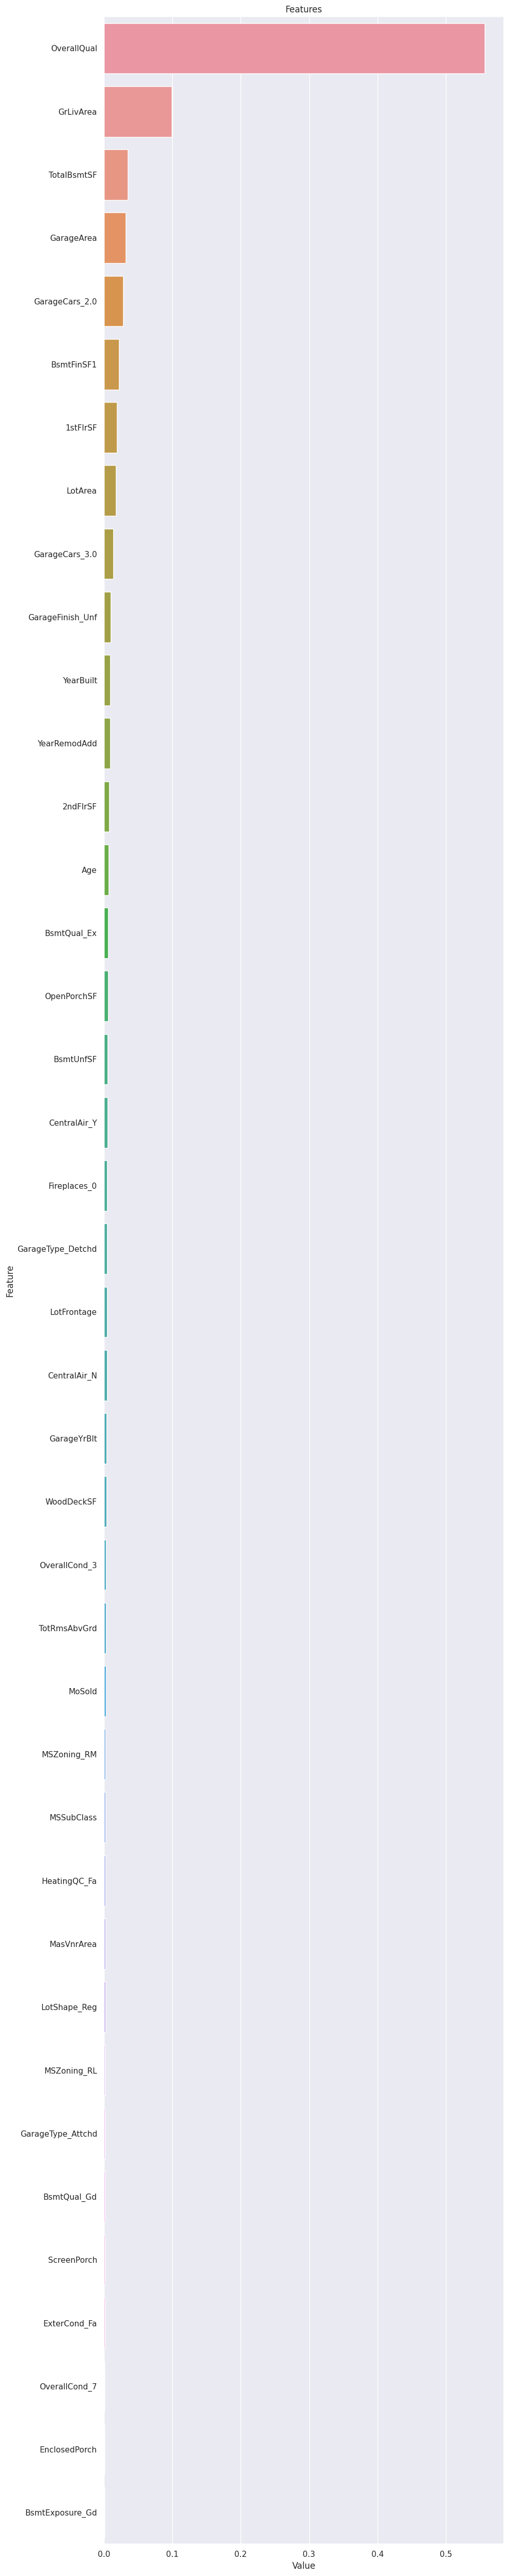

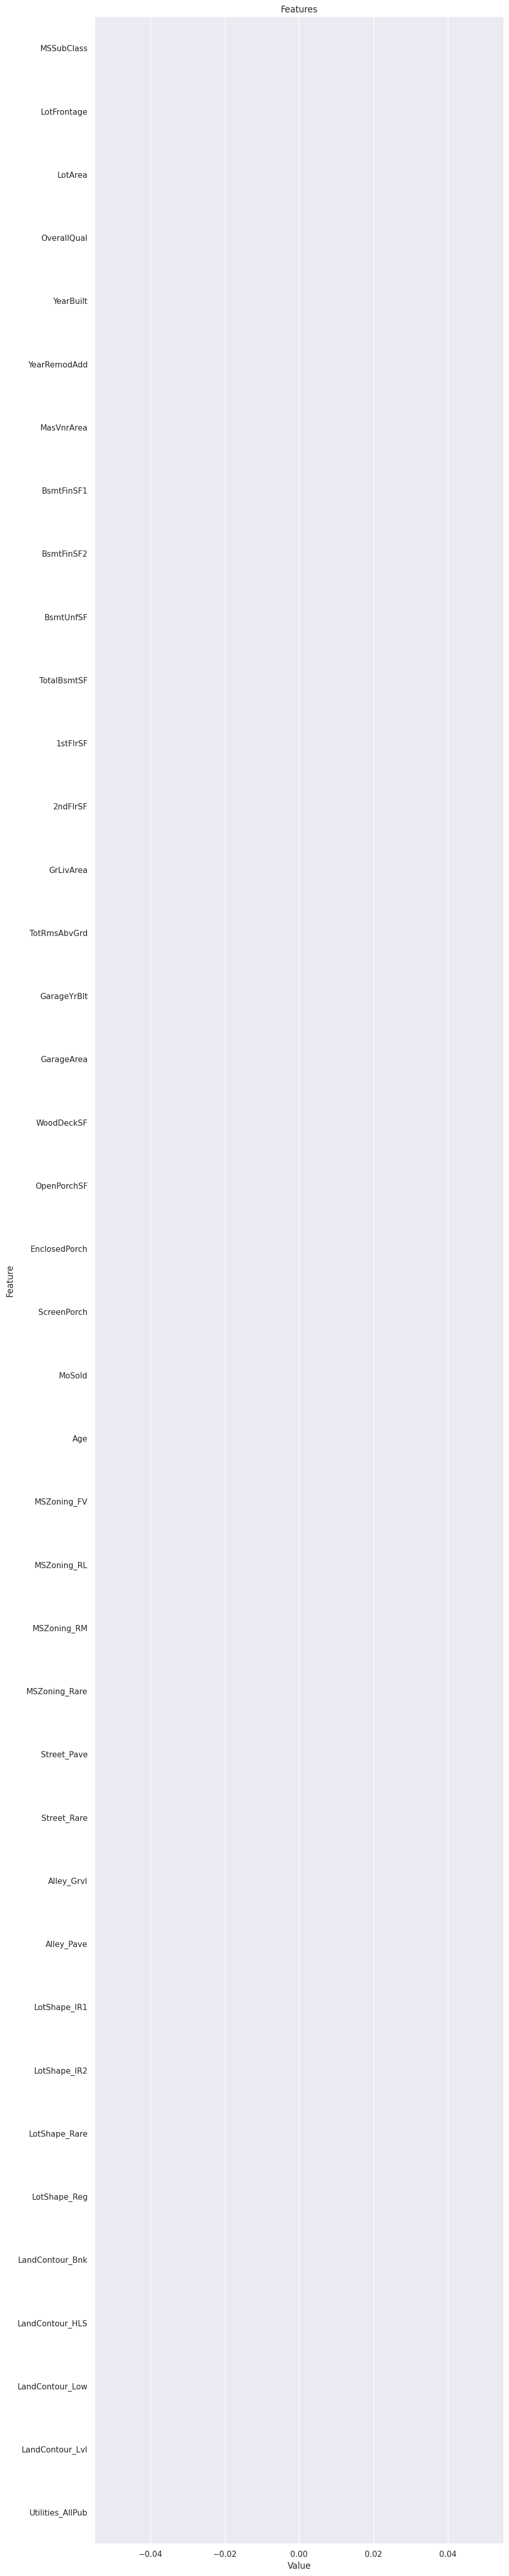

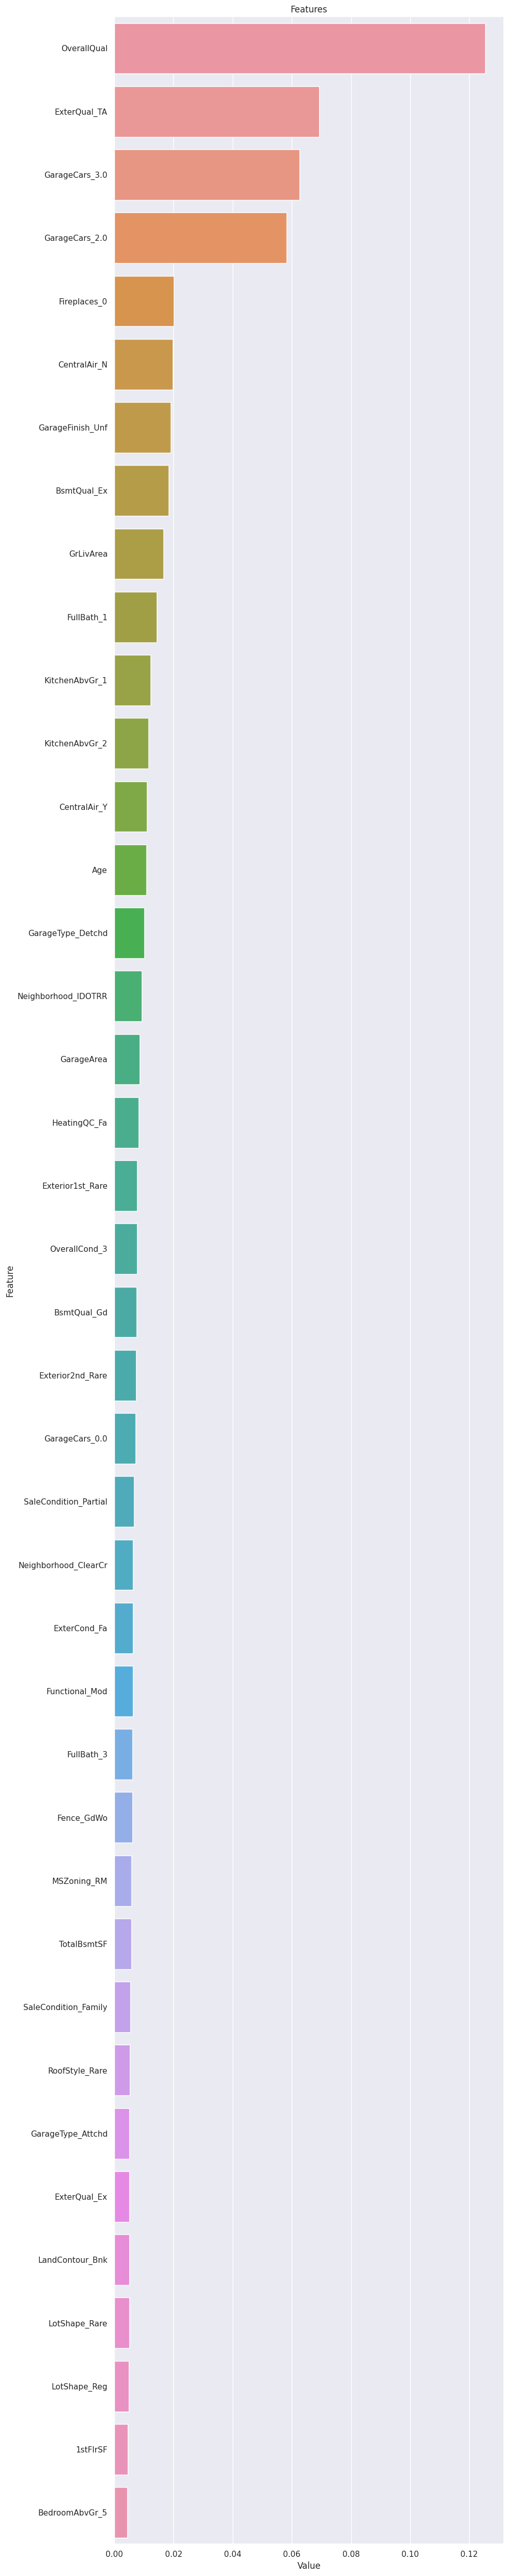

In [22]:

## Değişken Önem Düzeyi

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 50))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:40])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X_train)
plot_importance(catboost_final, X_train)
plot_importance(xgb_final, X_train)


In [23]:

####Tahminleme

test_df = df2[df2['SalePrice'].isnull()]

predictions = test_df.drop(["Id"], axis=1)
newpred=cbost.predict(predictions)
newpred_original = np.expm1(newpred)

actual_new=pd.DataFrame({"Id":test_df["Id"],"SalePrice":newpred_original})

actual_new['Id'] = actual_new['Id'].astype('Int32')
actual_new.to_csv('PredictHouse.csv', index=False)